In [1]:
import numpy as np
import aacgmv2
import datetime
import matplotlib.pyplot as plt
import gzip
import pickle
from scipy import interpolate
import bisect
import os
import scipy.io


import matplotlib.gridspec as gridspec
from solar import daynight_terminator
from scipy.interpolate import interp1d


%load_ext autoreload
# %autoreload 2
# %matplotlib notebook
# %matplotlib notebook
%matplotlib inline


# My own modules:
from xformpy import xflib
xf = xflib.xflib(lib_path='xformpy/libxformd.so')
from index_helpers import load_Kp

### Energy density vs Longitude and L-shell plot
#### This is the first half of GLD_statistics_energydensity from the thesis

In [2]:
# Load stencil data:

# stencil_fn = '../outputs/stencil_dict_Lshell_power_daynite_updated.pklz'
stencil_fn = 'outputs/stencils/stencil_dict_Lshell_power_daynite_mode6_v3_jan_2018.pklz'


with gzip.open(stencil_fn, 'rb') as file:
    stencil_dict = pickle.load(file, encoding='latin1')

In [3]:
# Load Kp
Ktimes, Kp = load_Kp('data/indices/Kp_1999_2018.dat')
Ktimes = [k + datetime.timedelta(minutes=90) for k in Ktimes]  # 3-hour bins; the original script labeled them in the middle of the bin
Ktimes = np.array(Ktimes)
Kp = np.array(Kp)

# Get Kpmax -- max value of Kp over the last 24 hours (8 bins):
Kpmax = np.max([Kp[0:-8],Kp[1:-7],Kp[2:-6], Kp[3:-5], Kp[4:-4],Kp[5:-3],Kp[6:-2], Kp[7:-1], Kp[8:]],axis=0)
Kpmtimes = Ktimes[8:]
unique_Kpm = np.unique(Kpmax)

In [4]:
# Precalculate stencils:
# This block interpolates stencils over Kp, input latitude, and MLT (day or night)
# This will break after kp 8 -- that's expected, since I only simulated up to kp8 in the stencils.

stencil_lons = stencil_dict['lons']
inlats = []
inmlts = []
inkps  = []
for k in stencil_dict['data'].keys():
    inlats.append(k[2])
    inmlts.append(k[1])
    inkps.append(k[0])
inlats = np.array(sorted(np.unique(inlats)))
inmlts = np.array(sorted(np.unique(inmlts)))
inkps  = np.array(sorted(np.unique(inkps)))

stencil_Lsh = stencil_dict['Lshells']
stencil_lons = stencil_dict['lons']
print(stencil_Lsh)
print(stencil_lons)

# Set up interpolator:
stencil_arr = np.zeros([len(inmlts), len(inlats), len(inkps), len(stencil_Lsh), len(stencil_lons)])

for key in stencil_dict['data'].keys():
    ilat_ind = bisect.bisect_left(inlats, key[2])
    imlt_ind = bisect.bisect_left(inmlts, key[1])
    ikp_ind  = bisect.bisect_left(inkps, key[0])    
#     stencil_arr[imlt_ind, ilat_ind, ikp_ind, :, :] = stencil_dict['data'][key]
    stencil_arr[imlt_ind, ilat_ind, ikp_ind, :, :] = stencil_dict['data'][key]


interp_nite = interpolate.RegularGridInterpolator([inlats, inkps, stencil_Lsh, stencil_lons],
                                                stencil_arr[0], bounds_error=True, fill_value=0)
interp_day = interpolate.RegularGridInterpolator([inlats, inkps, stencil_Lsh, stencil_lons],
                                                stencil_arr[1], bounds_error=True, fill_value=0)

# Set up grid:
gridlons = np.arange(-180, 180, stencil_dict['d_lon'])
gridLs = stencil_dict['Lshells']
pwr_map = np.zeros([len(gridlons), len(gridLs)])


# Precalculate interpolated stencils:
precalc_stencils = dict()
xx, yy = np.meshgrid(stencil_Lsh, stencil_lons)

for kp in np.unique(Kpmax):
    for lat in np.unique(inlats):
        for mlt in np.unique(inmlts):
            key = (int(np.round(10.*kp)), int(lat), int(mlt))
            print(key,  end="")

            pts = list(zip(lat*np.ones_like(xx.ravel()),
                      kp*np.ones_like(xx.ravel()), 
                      xx.ravel(), 
                      yy.ravel()))
            if (mlt == inmlts[0]):
                tmp = interp_nite(pts).reshape(len(stencil_lons), len(stencil_Lsh))
            elif (mlt == inmlts[1]):
                tmp = interp_day(pts).reshape(len(stencil_lons), len(stencil_Lsh))
            
            precalc_stencils[key] = tmp


[1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85
 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55
 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25
 3.3  3.35 3.4  3.45 3.5  3.55 3.6  3.65 3.7  3.75 3.8  3.85 3.9  3.95
 4.   4.05 4.1  4.15 4.2  4.25 4.3  4.35 4.4  4.45 4.5  4.55 4.6  4.65
 4.7  4.75 4.8  4.85 4.9  4.95 5.   5.05 5.1  5.15 5.2  5.25 5.3  5.35
 5.4  5.45 5.5  5.55 5.6  5.65 5.7  5.75 5.8  5.85 5.9  5.95 6.   6.05
 6.1  6.15 6.2  6.25 6.3  6.35 6.4  6.45 6.5  6.55 6.6  6.65 6.7  6.75
 6.8  6.85 6.9  6.95 7.   7.05 7.1  7.15 7.2  7.25 7.3  7.35 7.4  7.45
 7.5  7.55 7.6  7.65 7.7  7.75 7.8  7.85 7.9  7.95]
[-20.   -19.75 -19.5  -19.25 -19.   -18.75 -18.5  -18.25 -18.   -17.75
 -17.5  -17.25 -17.   -16.75 -16.5  -16.25 -16.   -15.75 -15.5  -15.25
 -15.   -14.75 -14.5  -14.25 -14.   -13.75 -13.5  -13.25 -13.   -12.75
 -12.5  -12.25 -12.   -11.75 -11.5  -11.25 -11.   -10.75 -10.5  -10.25
 -10.    -9.75  -9.5   -9

(0, 15, 0)(0, 15, 12)(0, 16, 0)(0, 16, 12)(0, 17, 0)(0, 17, 12)(0, 18, 0)(0, 18, 12)(0, 19, 0)(0, 19, 12)(0, 20, 0)(0, 20, 12)(0, 21, 0)(0, 21, 12)(0, 22, 0)(0, 22, 12)(0, 23, 0)(0, 23, 12)(0, 24, 0)(0, 24, 12)(0, 25, 0)(0, 25, 12)(0, 26, 0)(0, 26, 12)(0, 27, 0)(0, 27, 12)(0, 28, 0)(0, 28, 12)(0, 29, 0)(0, 29, 12)(0, 30, 0)(0, 30, 12)(0, 31, 0)(0, 31, 12)(0, 32, 0)(0, 32, 12)(0, 33, 0)(0, 33, 12)(0, 34, 0)(0, 34, 12)(0, 35, 0)(0, 35, 12)(0, 36, 0)(0, 36, 12)(0, 37, 0)(0, 37, 12)(0, 38, 0)(0, 38, 12)(0, 39, 0)(0, 39, 12)(0, 40, 0)(0, 40, 12)(0, 41, 0)(0, 41, 12)(0, 42, 0)(0, 42, 12)(0, 43, 0)(0, 43, 12)(0, 44, 0)(0, 44, 12)(0, 45, 0)(0, 45, 12)(0, 46, 0)(0, 46, 12)(0, 47, 0)(0, 47, 12)(0, 48, 0)(0, 48, 12)(0, 49, 0)(0, 49, 12)(0, 50, 0)(0, 50, 12)(0, 51, 0)(0, 51, 12)(0, 52, 0)(0, 52, 12)(0, 53, 0)(0, 53, 12)(0, 54, 0)(0, 54, 12)(0, 55, 0)(0, 55, 12)(3, 15, 0)(3, 15, 12)(3, 16, 0)(3, 16, 12)(3, 17, 0)(3, 17, 12)(3, 18, 0)(3, 18, 12)(3, 19, 0)(3, 19, 12)(3, 20, 0)(3, 20, 12)(3, 21, 0)(3,

(30, 15, 12)(30, 16, 0)(30, 16, 12)(30, 17, 0)(30, 17, 12)(30, 18, 0)(30, 18, 12)(30, 19, 0)(30, 19, 12)(30, 20, 0)(30, 20, 12)(30, 21, 0)(30, 21, 12)(30, 22, 0)(30, 22, 12)(30, 23, 0)(30, 23, 12)(30, 24, 0)(30, 24, 12)(30, 25, 0)(30, 25, 12)(30, 26, 0)(30, 26, 12)(30, 27, 0)(30, 27, 12)(30, 28, 0)(30, 28, 12)(30, 29, 0)(30, 29, 12)(30, 30, 0)(30, 30, 12)(30, 31, 0)(30, 31, 12)(30, 32, 0)(30, 32, 12)(30, 33, 0)(30, 33, 12)(30, 34, 0)(30, 34, 12)(30, 35, 0)(30, 35, 12)(30, 36, 0)(30, 36, 12)(30, 37, 0)(30, 37, 12)(30, 38, 0)(30, 38, 12)(30, 39, 0)(30, 39, 12)(30, 40, 0)(30, 40, 12)(30, 41, 0)(30, 41, 12)(30, 42, 0)(30, 42, 12)(30, 43, 0)(30, 43, 12)(30, 44, 0)(30, 44, 12)(30, 45, 0)(30, 45, 12)(30, 46, 0)(30, 46, 12)(30, 47, 0)(30, 47, 12)(30, 48, 0)(30, 48, 12)(30, 49, 0)(30, 49, 12)(30, 50, 0)(30, 50, 12)(30, 51, 0)(30, 51, 12)(30, 52, 0)(30, 52, 12)(30, 53, 0)(30, 53, 12)(30, 54, 0)(30, 54, 12)(30, 55, 0)(30, 55, 12)(33, 15, 0)(33, 15, 12)(33, 16, 0)(33, 16, 12)(33, 17, 0)(33, 17, 12

(57, 45, 0)(57, 45, 12)(57, 46, 0)(57, 46, 12)(57, 47, 0)(57, 47, 12)(57, 48, 0)(57, 48, 12)(57, 49, 0)(57, 49, 12)(57, 50, 0)(57, 50, 12)(57, 51, 0)(57, 51, 12)(57, 52, 0)(57, 52, 12)(57, 53, 0)(57, 53, 12)(57, 54, 0)(57, 54, 12)(57, 55, 0)(57, 55, 12)(60, 15, 0)(60, 15, 12)(60, 16, 0)(60, 16, 12)(60, 17, 0)(60, 17, 12)(60, 18, 0)(60, 18, 12)(60, 19, 0)(60, 19, 12)(60, 20, 0)(60, 20, 12)(60, 21, 0)(60, 21, 12)(60, 22, 0)(60, 22, 12)(60, 23, 0)(60, 23, 12)(60, 24, 0)(60, 24, 12)(60, 25, 0)(60, 25, 12)(60, 26, 0)(60, 26, 12)(60, 27, 0)(60, 27, 12)(60, 28, 0)(60, 28, 12)(60, 29, 0)(60, 29, 12)(60, 30, 0)(60, 30, 12)(60, 31, 0)(60, 31, 12)(60, 32, 0)(60, 32, 12)(60, 33, 0)(60, 33, 12)(60, 34, 0)(60, 34, 12)(60, 35, 0)(60, 35, 12)(60, 36, 0)(60, 36, 12)(60, 37, 0)(60, 37, 12)(60, 38, 0)(60, 38, 12)(60, 39, 0)(60, 39, 12)(60, 40, 0)(60, 40, 12)(60, 41, 0)(60, 41, 12)(60, 42, 0)(60, 42, 12)(60, 43, 0)(60, 43, 12)(60, 44, 0)(60, 44, 12)(60, 45, 0)(60, 45, 12)(60, 46, 0)(60, 46, 12)(60, 47, 0)

ValueError: One of the requested xi is out of bounds in dimension 1

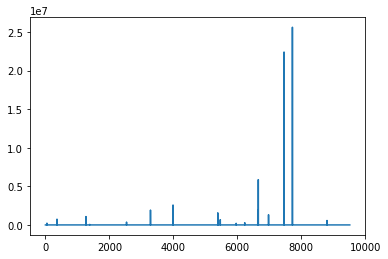

In [5]:
# Check that we don't have any days with all zeroes:
data_path = 'outputs/GLDstats_v11/CGM/data/'
# data_path = 'outputs/GLDstats_v11/MAG/data/'
d = os.listdir(data_path)
files = [x for x in d if x.endswith('.pklz')]

# for f in files:
#     with gzip.open(os.path.join(data_path,f),'rb') as file:
#         thingy = pickle.load(file)
#         print(f'{f} day: {np.sum(thingy["cur_map"]["day"])} nite: {np.sum(thingy["cur_map"]["night"])}')

filetimes = []
for fi in files:
    it = datetime.datetime.strptime(fi[:-5],'%m_%d_%Y_%H_%M')
    filetimes.append(it)
    
filetimes = sorted(filetimes)
vec = [x.total_seconds() for x in np.diff(filetimes)]
fig, ax = plt.subplots(1,1)
ax.plot(vec)

In [6]:
# data_path = '../outputs/GLDstats_v8/data/'  # From thesis
# data_path  = 'outputs/GLDstats_v10_CGM/year_avgs/'
# data_path = 'outputs/GLDstats_v10_CGM/data'
data_path = 'outputs/GLDstats_v11/CGM/data/'
# data_path = 'outputs/GLDstats_v11/MAG/data/'
d = os.listdir(data_path)
files = [x for x in d if x.endswith('.pklz')]
# intimes = [datetime.datetime.strptime(x,'%m_%d_T%H-%M-%S.pklz') for x in d if x.endswith('.pklz')]

# stencil_duration = 20. # seconds
# file_duration = 3*3600. # 3 hours in seconds
# period_factor = stencil_duration/file_duration

# Separate maps for dayside and nightside contributions
pwr_maps = dict()
# for mlt in inmlts:
#     pwr_maps[mlt] = np.zeros([len(longrid), len(Lgrid)])

gridlats = np.arange(-90, 91, 1)
gridlons_out= np.arange(-180,180.25,0.25)
gridlons_in = np.arange(-180,180,1)  
# cur_map_total = np.zeros([180, 360])

# This one we'll keep split up for each 3-hr block
pwr_maps_canonical_year = dict()

pwr_maps_thesis_method = dict()

count=0
counts = dict()

# Locate all files with common day, month, and time of day, for averaging:

filetime_dict = dict()
# List the files with common time of year
for fi in files:
    it = datetime.datetime.strptime(fi[:-5],'%m_%d_%Y_%H_%M')
    key = it.replace(year=2000) # Arbitrary year, but keep it above the unix epoch for plotting reasons
    if key in filetime_dict:
        filetime_dict[key].append(fi)
    else:
        filetime_dict[key] = [fi]



for cc, filetime_key in enumerate(sorted(filetime_dict.keys())):
    v = filetime_dict[filetime_key]
    print(f'Doing {filetime_key}  ({cc} of {len(filetime_dict)})')

    
    for filename in v:
        print(f'\t loading {filename}', end="")
        
        # Initialize the temporary power map -- this will be the average of all 3-hr periods across different years
        temp_power_map = dict()


        # --------- Load and process each day-of-year entry in the current list: ---------
        with gzip.open(os.path.join(data_path, filename)) as f:
            thingy = pickle.load(f)

#             intime = datetime.datetime.strptime(filename,'%m_%d_T%H-%M-%S.pklz')
            intime = datetime.datetime.strptime(filename,'%m_%d_%Y_%H_%M.pklz')

            tcenter = intime + datetime.timedelta(hours=1.5)

            Kpm_index = bisect.bisect_left(Kpmtimes, intime)
            Kpm = min(8,Kpmax[Kpm_index])  # Interpolation is only good up to kp 8
            print(f' -- Kp_max = {Kpm}')

            for is_day in ['day','night']:

                # Load data for day or night
                cur_map = thingy['cur_map'][is_day]
                
                # Just do the hits, please
                todo = np.where(cur_map > 0)
                for x,y in zip(todo[0], todo[1]):
                    I = cur_map[x,y] # sum of squared input currents, in A^2 at the current bin
                    
                    # Latitude and longitude
                    cur_lat = gridlats[x]
                    cur_lon = gridlons_in[y]
                    
                    # Stencil keys -- Kp, latitude, and MLT (0 or 12)
                    if 'day' in is_day:
                        key = (int(np.round(10.*Kpm)), cur_lat, 12)
                    elif 'night' in is_day:
                        key = (int(np.round(10.*Kpm)), cur_lat, 0)

                    # You can swap out different outkeys here, to look at data over different breakouts.
                    # here, we're just doing it by dayside (true), and nightside (false)
                    outkey = is_day

                    if key in precalc_stencils:
                        # Load the corresponding stencil and scale it by our (summed, squared) current
                        stencil = precalc_stencils[key]*I
                        
                        # Find the center index to apply the stencil at
                        lon_center_ind = bisect.bisect_left(gridlons_out, cur_lon)
                        lonleft  = lon_center_ind - int(np.floor(len(stencil_lons)/2)) - 1
                        lonright = lon_center_ind + int(np.floor(len(stencil_lons)/2))

                        if not outkey in temp_power_map:
                            # initialize temp_power_map with zeros
                            temp_power_map[outkey] = np.zeros([len(gridlons_out), len(gridLs)])
                        
                        # Add in the stencil:
                        if lonleft < 0:
                            # wrap left
                            temp_power_map[outkey][:lonright,: ]+= stencil[np.abs(lonleft):,:]
                            temp_power_map[outkey][(len(gridlons) - np.abs(lonleft) + 1):,:] += stencil[0:np.abs(lonleft),:]
                        elif lonright > len(gridlons):
                            # wrap right
                            temp_power_map[outkey][lonleft:len(gridlons),:] += stencil[0:len(gridlons) - lonleft, :]
                            temp_power_map[outkey][0:np.abs(lonright) - len(gridlons), :] += stencil[len(gridlons) - lonleft,:]
                        else:
                            # Middle
                            temp_power_map[outkey][lonleft:lonright, :] += stencil

                    
    # Normalize by number of instances:
    print(f'divisor: {len(v)}')
    for el in temp_power_map:
        if el not in pwr_maps:
            # Initialize w/ zeros
            pwr_maps[el] = np.zeros([len(gridlons_out), len(gridLs)])
        else:
            # Add to rolling sum
            pwr_maps[el] += (temp_power_map[el])/(1.0*len(v))
        
        # Save this map in the canonical year dict
        pwr_maps_canonical_year[(filetime_key,el)] = (temp_power_map[el])/(1.0*len(v))
        
        # This one is the sum of every entry, regardless of day-of-year. 
        # The only difference between this and the thesis result is the cleaned GLD set........
        if not el in pwr_maps_thesis_method:
            pwr_maps_thesis_method[el] = np.zeros([len(gridlons_out), len(gridLs)])
        else:
            pwr_maps_thesis_method[el] += temp_power_map[el]

Doing 2000-01-01 00:00:00  (0 of 2920)
	 loading 01_01_2013_00_00.pklz -- Kp_max = 0.3
	 loading 01_01_2016_00_00.pklz -- Kp_max = 5.7
	 loading 01_01_2014_00_00.pklz -- Kp_max = 2.0
	 loading 01_01_2018_00_00.pklz -- Kp_max = 2.0
divisor: 4
Doing 2000-01-01 03:00:00  (1 of 2920)
	 loading 01_01_2014_03_00.pklz -- Kp_max = 2.0
	 loading 01_01_2013_03_00.pklz -- Kp_max = 0.7
	 loading 01_01_2016_03_00.pklz -- Kp_max = 6.0
	 loading 01_01_2018_03_00.pklz -- Kp_max = 3.3
divisor: 4
Doing 2000-01-01 06:00:00  (2 of 2920)
	 loading 01_01_2018_06_00.pklz -- Kp_max = 3.7
	 loading 01_01_2016_06_00.pklz -- Kp_max = 6.0
	 loading 01_01_2013_06_00.pklz -- Kp_max = 0.7
	 loading 01_01_2014_06_00.pklz -- Kp_max = 2.0
divisor: 4
Doing 2000-01-01 09:00:00  (3 of 2920)
	 loading 01_01_2013_09_00.pklz -- Kp_max = 0.7
	 loading 01_01_2016_09_00.pklz -- Kp_max = 6.0
	 loading 01_01_2014_09_00.pklz -- Kp_max = 2.0
	 loading 01_01_2018_09_00.pklz -- Kp_max = 3.7
divisor: 4
Doing 2000-01-01 12:00:00  (4 of

Doing 2000-01-05 09:00:00  (35 of 2920)
	 loading 01_05_2018_09_00.pklz -- Kp_max = 1.7
	 loading 01_05_2013_09_00.pklz -- Kp_max = 1.0
	 loading 01_05_2016_09_00.pklz -- Kp_max = 2.0
	 loading 01_05_2014_09_00.pklz -- Kp_max = 2.3
divisor: 4
Doing 2000-01-05 12:00:00  (36 of 2920)
	 loading 01_05_2018_12_00.pklz -- Kp_max = 1.7
	 loading 01_05_2014_12_00.pklz -- Kp_max = 2.3
	 loading 01_05_2016_12_00.pklz -- Kp_max = 2.0
	 loading 01_05_2013_12_00.pklz -- Kp_max = 1.0
divisor: 4
Doing 2000-01-05 15:00:00  (37 of 2920)
	 loading 01_05_2014_15_00.pklz -- Kp_max = 2.3
	 loading 01_05_2016_15_00.pklz -- Kp_max = 2.0
	 loading 01_05_2013_15_00.pklz -- Kp_max = 1.0
	 loading 01_05_2018_15_00.pklz -- Kp_max = 1.7
divisor: 4
Doing 2000-01-05 18:00:00  (38 of 2920)
	 loading 01_05_2018_18_00.pklz -- Kp_max = 1.7
	 loading 01_05_2016_18_00.pklz -- Kp_max = 2.0
	 loading 01_05_2013_18_00.pklz -- Kp_max = 1.0
	 loading 01_05_2014_18_00.pklz -- Kp_max = 2.0
divisor: 4
Doing 2000-01-05 21:00:00  (

	 loading 01_09_2013_15_00.pklz -- Kp_max = 2.3
	 loading 01_09_2016_15_00.pklz -- Kp_max = 3.0
divisor: 4
Doing 2000-01-09 18:00:00  (70 of 2920)
	 loading 01_09_2013_18_00.pklz -- Kp_max = 2.3
	 loading 01_09_2016_18_00.pklz -- Kp_max = 2.0
	 loading 01_09_2014_18_00.pklz -- Kp_max = 3.0
	 loading 01_09_2018_18_00.pklz -- Kp_max = 3.7
divisor: 4
Doing 2000-01-09 21:00:00  (71 of 2920)
	 loading 01_09_2018_21_00.pklz -- Kp_max = 3.7
	 loading 01_09_2016_21_00.pklz -- Kp_max = 2.0
	 loading 01_09_2013_21_00.pklz -- Kp_max = 2.3
	 loading 01_09_2014_21_00.pklz -- Kp_max = 3.0
divisor: 4
Doing 2000-01-10 00:00:00  (72 of 2920)
	 loading 01_10_2016_00_00.pklz -- Kp_max = 2.0
	 loading 01_10_2013_00_00.pklz -- Kp_max = 2.3
	 loading 01_10_2014_00_00.pklz -- Kp_max = 3.0
	 loading 01_10_2018_00_00.pklz -- Kp_max = 3.7
divisor: 4
Doing 2000-01-10 03:00:00  (73 of 2920)
	 loading 01_10_2014_03_00.pklz -- Kp_max = 3.0
	 loading 01_10_2016_03_00.pklz -- Kp_max = 2.3
	 loading 01_10_2013_03_00.p

	 loading 01_13_2018_15_00.pklz -- Kp_max = 2.0
divisor: 4
Doing 2000-01-13 18:00:00  (102 of 2920)
	 loading 01_13_2018_18_00.pklz -- Kp_max = 2.0
	 loading 01_13_2016_18_00.pklz -- Kp_max = 4.0
	 loading 01_13_2013_18_00.pklz -- Kp_max = 2.7
	 loading 01_13_2014_18_00.pklz -- Kp_max = 3.3
divisor: 4
Doing 2000-01-13 21:00:00  (103 of 2920)
	 loading 01_13_2013_21_00.pklz -- Kp_max = 2.7
	 loading 01_13_2016_21_00.pklz -- Kp_max = 4.0
	 loading 01_13_2014_21_00.pklz -- Kp_max = 3.3
	 loading 01_13_2018_21_00.pklz -- Kp_max = 3.0
divisor: 4
Doing 2000-01-14 00:00:00  (104 of 2920)
	 loading 01_14_2018_00_00.pklz -- Kp_max = 3.0
	 loading 01_14_2016_00_00.pklz -- Kp_max = 4.0
	 loading 01_14_2013_00_00.pklz -- Kp_max = 3.7
	 loading 01_14_2014_00_00.pklz -- Kp_max = 3.3
divisor: 4
Doing 2000-01-14 03:00:00  (105 of 2920)
	 loading 01_14_2018_03_00.pklz -- Kp_max = 4.7
	 loading 01_14_2014_03_00.pklz -- Kp_max = 3.3
	 loading 01_14_2016_03_00.pklz -- Kp_max = 4.0
	 loading 01_14_2013_03_

	 loading 01_18_2016_12_00.pklz -- Kp_max = 1.0
	 loading 01_18_2018_12_00.pklz -- Kp_max = 0.7
divisor: 3
Doing 2000-01-18 15:00:00  (141 of 2920)
	 loading 01_18_2018_15_00.pklz -- Kp_max = 0.3
	 loading 01_18_2014_15_00.pklz -- Kp_max = 1.7
	 loading 01_18_2016_15_00.pklz -- Kp_max = 1.0
divisor: 3
Doing 2000-01-18 18:00:00  (142 of 2920)
	 loading 01_18_2016_18_00.pklz -- Kp_max = 1.7
	 loading 01_18_2014_18_00.pklz -- Kp_max = 1.7
	 loading 01_18_2018_18_00.pklz -- Kp_max = 0.3
divisor: 3
Doing 2000-01-18 21:00:00  (143 of 2920)
	 loading 01_18_2018_21_00.pklz -- Kp_max = 0.3
	 loading 01_18_2016_21_00.pklz -- Kp_max = 1.7
	 loading 01_18_2014_21_00.pklz -- Kp_max = 1.7
divisor: 3
Doing 2000-01-19 00:00:00  (144 of 2920)
	 loading 01_19_2014_00_00.pklz -- Kp_max = 1.7
	 loading 01_19_2016_00_00.pklz -- Kp_max = 3.0
	 loading 01_19_2018_00_00.pklz -- Kp_max = 0.3
divisor: 3
Doing 2000-01-19 03:00:00  (145 of 2920)
	 loading 01_19_2016_03_00.pklz -- Kp_max = 4.3
	 loading 01_19_2014

	 loading 01_23_2015_03_00.pklz -- Kp_max = 3.7
	 loading 01_23_2018_03_00.pklz -- Kp_max = 3.3
divisor: 4
Doing 2000-01-23 06:00:00  (178 of 2920)
	 loading 01_23_2018_06_00.pklz -- Kp_max = 3.3
	 loading 01_23_2015_06_00.pklz -- Kp_max = 3.0
	 loading 01_23_2014_06_00.pklz -- Kp_max = 3.3
	 loading 01_23_2016_06_00.pklz -- Kp_max = 3.3
divisor: 4
Doing 2000-01-23 09:00:00  (179 of 2920)
	 loading 01_23_2014_09_00.pklz -- Kp_max = 3.3
	 loading 01_23_2016_09_00.pklz -- Kp_max = 3.7
	 loading 01_23_2015_09_00.pklz -- Kp_max = 3.0
	 loading 01_23_2018_09_00.pklz -- Kp_max = 3.3
divisor: 4
Doing 2000-01-23 12:00:00  (180 of 2920)
	 loading 01_23_2016_12_00.pklz -- Kp_max = 3.7
	 loading 01_23_2014_12_00.pklz -- Kp_max = 3.3
	 loading 01_23_2018_12_00.pklz -- Kp_max = 3.3
	 loading 01_23_2015_12_00.pklz -- Kp_max = 3.0
divisor: 4
Doing 2000-01-23 15:00:00  (181 of 2920)
	 loading 01_23_2015_15_00.pklz -- Kp_max = 3.0
	 loading 01_23_2018_15_00.pklz -- Kp_max = 3.3
	 loading 01_23_2016_15_

	 loading 01_27_2015_06_00.pklz -- Kp_max = 4.0
divisor: 4
Doing 2000-01-27 09:00:00  (211 of 2920)
	 loading 01_27_2015_09_00.pklz -- Kp_max = 4.0
	 loading 01_27_2014_09_00.pklz -- Kp_max = 1.7
	 loading 01_27_2013_09_00.pklz -- Kp_max = 4.0
	 loading 01_27_2016_09_00.pklz -- Kp_max = 2.0
divisor: 4
Doing 2000-01-27 12:00:00  (212 of 2920)
	 loading 01_27_2015_12_00.pklz -- Kp_max = 4.0
	 loading 01_27_2016_12_00.pklz -- Kp_max = 2.0
	 loading 01_27_2013_12_00.pklz -- Kp_max = 4.0
	 loading 01_27_2014_12_00.pklz -- Kp_max = 1.7
divisor: 4
Doing 2000-01-27 15:00:00  (213 of 2920)
	 loading 01_27_2016_15_00.pklz -- Kp_max = 2.0
	 loading 01_27_2013_15_00.pklz -- Kp_max = 4.0
	 loading 01_27_2014_15_00.pklz -- Kp_max = 1.7
	 loading 01_27_2015_15_00.pklz -- Kp_max = 3.0
divisor: 4
Doing 2000-01-27 18:00:00  (214 of 2920)
	 loading 01_27_2015_18_00.pklz -- Kp_max = 3.0
	 loading 01_27_2014_18_00.pklz -- Kp_max = 1.7
	 loading 01_27_2016_18_00.pklz -- Kp_max = 2.0
	 loading 01_27_2013_18_

	 loading 02_01_2013_06_00.pklz -- Kp_max = 2.0
	 loading 02_01_2016_06_00.pklz -- Kp_max = 3.7
	 loading 02_01_2014_06_00.pklz -- Kp_max = 0.7
divisor: 4
Doing 2000-02-01 09:00:00  (251 of 2920)
	 loading 02_01_2016_09_00.pklz -- Kp_max = 3.7
	 loading 02_01_2013_09_00.pklz -- Kp_max = 2.0
	 loading 02_01_2014_09_00.pklz -- Kp_max = 0.7
	 loading 02_01_2018_09_00.pklz -- Kp_max = 2.7
divisor: 4
Doing 2000-02-01 12:00:00  (252 of 2920)
	 loading 02_01_2014_12_00.pklz -- Kp_max = 0.7
	 loading 02_01_2013_12_00.pklz -- Kp_max = 2.0
	 loading 02_01_2016_12_00.pklz -- Kp_max = 3.7
	 loading 02_01_2018_12_00.pklz -- Kp_max = 2.7
divisor: 4
Doing 2000-02-01 15:00:00  (253 of 2920)
	 loading 02_01_2018_15_00.pklz -- Kp_max = 2.7
	 loading 02_01_2014_15_00.pklz -- Kp_max = 0.7
	 loading 02_01_2013_15_00.pklz -- Kp_max = 2.0
	 loading 02_01_2016_15_00.pklz -- Kp_max = 3.7
divisor: 4
Doing 2000-02-01 18:00:00  (254 of 2920)
	 loading 02_01_2013_18_00.pklz -- Kp_max = 2.0
	 loading 02_01_2014_18_

	 loading 02_06_2014_06_00.pklz -- Kp_max = 3.0
divisor: 4
Doing 2000-02-06 09:00:00  (291 of 2920)
	 loading 02_06_2013_09_00.pklz -- Kp_max = 1.3
	 loading 02_06_2014_09_00.pklz -- Kp_max = 3.0
	 loading 02_06_2018_09_00.pklz -- Kp_max = 3.0
	 loading 02_06_2015_09_00.pklz -- Kp_max = 3.3
divisor: 4
Doing 2000-02-06 12:00:00  (292 of 2920)
	 loading 02_06_2014_12_00.pklz -- Kp_max = 3.0
	 loading 02_06_2013_12_00.pklz -- Kp_max = 0.7
	 loading 02_06_2015_12_00.pklz -- Kp_max = 3.3
	 loading 02_06_2018_12_00.pklz -- Kp_max = 3.0
divisor: 4
Doing 2000-02-06 15:00:00  (293 of 2920)
	 loading 02_06_2018_15_00.pklz -- Kp_max = 3.0
	 loading 02_06_2015_15_00.pklz -- Kp_max = 3.3
	 loading 02_06_2014_15_00.pklz -- Kp_max = 3.0
	 loading 02_06_2013_15_00.pklz -- Kp_max = 0.7
divisor: 4
Doing 2000-02-06 18:00:00  (294 of 2920)
	 loading 02_06_2013_18_00.pklz -- Kp_max = 0.3
	 loading 02_06_2014_18_00.pklz -- Kp_max = 3.0
	 loading 02_06_2015_18_00.pklz -- Kp_max = 3.3
	 loading 02_06_2018_18_

	 loading 02_10_2015_15_00.pklz -- Kp_max = 2.3
	 loading 02_10_2018_15_00.pklz -- Kp_max = 2.3
	 loading 02_10_2014_15_00.pklz -- Kp_max = 4.0
	 loading 02_10_2013_15_00.pklz -- Kp_max = 1.7
divisor: 4
Doing 2000-02-10 18:00:00  (326 of 2920)
	 loading 02_10_2013_18_00.pklz -- Kp_max = 1.7
	 loading 02_10_2014_18_00.pklz -- Kp_max = 4.0
	 loading 02_10_2018_18_00.pklz -- Kp_max = 2.3
	 loading 02_10_2015_18_00.pklz -- Kp_max = 2.3
divisor: 4
Doing 2000-02-10 21:00:00  (327 of 2920)
	 loading 02_10_2018_21_00.pklz -- Kp_max = 2.3
	 loading 02_10_2015_21_00.pklz -- Kp_max = 2.3
	 loading 02_10_2013_21_00.pklz -- Kp_max = 2.0
	 loading 02_10_2014_21_00.pklz -- Kp_max = 4.0
divisor: 4
Doing 2000-02-11 00:00:00  (328 of 2920)
	 loading 02_11_2014_00_00.pklz -- Kp_max = 3.7
	 loading 02_11_2013_00_00.pklz -- Kp_max = 2.0
	 loading 02_11_2018_00_00.pklz -- Kp_max = 2.3
	 loading 02_11_2015_00_00.pklz -- Kp_max = 3.0
divisor: 4
Doing 2000-02-11 03:00:00  (329 of 2920)
	 loading 02_11_2013_03_

	 loading 02_15_2015_15_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-02-15 18:00:00  (366 of 2920)
	 loading 02_15_2015_18_00.pklz -- Kp_max = 3.0
	 loading 02_15_2018_18_00.pklz -- Kp_max = 4.7
	 loading 02_15_2013_18_00.pklz -- Kp_max = 2.3
divisor: 3
Doing 2000-02-15 21:00:00  (367 of 2920)
	 loading 02_15_2013_21_00.pklz -- Kp_max = 2.3
	 loading 02_15_2015_21_00.pklz -- Kp_max = 3.0
	 loading 02_15_2018_21_00.pklz -- Kp_max = 4.7
divisor: 3
Doing 2000-02-16 00:00:00  (368 of 2920)
	 loading 02_16_2013_00_00.pklz -- Kp_max = 2.0
	 loading 02_16_2015_00_00.pklz -- Kp_max = 3.0
	 loading 02_16_2018_00_00.pklz -- Kp_max = 4.7
divisor: 3
Doing 2000-02-16 03:00:00  (369 of 2920)
	 loading 02_16_2013_03_00.pklz -- Kp_max = 2.0
	 loading 02_16_2018_03_00.pklz -- Kp_max = 4.7
	 loading 02_16_2015_03_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-02-16 06:00:00  (370 of 2920)
	 loading 02_16_2015_06_00.pklz -- Kp_max = 3.0
	 loading 02_16_2018_06_00.pklz -- Kp_max = 4.7
	 loading 02_16_2013

divisor: 3
Doing 2000-02-21 00:00:00  (408 of 2920)
	 loading 02_21_2015_00_00.pklz -- Kp_max = 2.0
	 loading 02_21_2018_00_00.pklz -- Kp_max = 2.7
	 loading 02_21_2013_00_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-02-21 03:00:00  (409 of 2920)
	 loading 02_21_2018_03_00.pklz -- Kp_max = 2.7
	 loading 02_21_2015_03_00.pklz -- Kp_max = 2.7
	 loading 02_21_2013_03_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-02-21 06:00:00  (410 of 2920)
	 loading 02_21_2013_06_00.pklz -- Kp_max = 3.0
	 loading 02_21_2015_06_00.pklz -- Kp_max = 2.7
	 loading 02_21_2018_06_00.pklz -- Kp_max = 1.3
divisor: 3
Doing 2000-02-21 09:00:00  (411 of 2920)
	 loading 02_21_2018_09_00.pklz -- Kp_max = 1.3
	 loading 02_21_2015_09_00.pklz -- Kp_max = 2.7
	 loading 02_21_2013_09_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-02-21 12:00:00  (412 of 2920)
	 loading 02_21_2015_12_00.pklz -- Kp_max = 2.7
	 loading 02_21_2018_12_00.pklz -- Kp_max = 2.0
	 loading 02_21_2013_12_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 200

	 loading 02_26_2018_06_00.pklz -- Kp_max = 2.0
	 loading 02_26_2015_06_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-02-26 09:00:00  (451 of 2920)
	 loading 02_26_2015_09_00.pklz -- Kp_max = 3.0
	 loading 02_26_2018_09_00.pklz -- Kp_max = 2.0
	 loading 02_26_2013_09_00.pklz -- Kp_max = 1.7
divisor: 3
Doing 2000-02-26 12:00:00  (452 of 2920)
	 loading 02_26_2018_12_00.pklz -- Kp_max = 2.0
	 loading 02_26_2015_12_00.pklz -- Kp_max = 3.0
	 loading 02_26_2013_12_00.pklz -- Kp_max = 1.7
divisor: 3
Doing 2000-02-26 15:00:00  (453 of 2920)
	 loading 02_26_2013_15_00.pklz -- Kp_max = 1.7
	 loading 02_26_2015_15_00.pklz -- Kp_max = 3.0
	 loading 02_26_2018_15_00.pklz -- Kp_max = 2.0
divisor: 3
Doing 2000-02-26 18:00:00  (454 of 2920)
	 loading 02_26_2018_18_00.pklz -- Kp_max = 2.0
	 loading 02_26_2015_18_00.pklz -- Kp_max = 2.7
	 loading 02_26_2013_18_00.pklz -- Kp_max = 1.7
divisor: 3
Doing 2000-02-26 21:00:00  (455 of 2920)
	 loading 02_26_2013_21_00.pklz -- Kp_max = 2.0
	 loading 02_26_2018

	 loading 03_03_2013_15_00.pklz -- Kp_max = 3.3
divisor: 3
Doing 2000-03-03 18:00:00  (494 of 2920)
	 loading 03_03_2013_18_00.pklz -- Kp_max = 3.3
	 loading 03_03_2018_18_00.pklz -- Kp_max = 2.0
	 loading 03_03_2015_18_00.pklz -- Kp_max = 3.7
divisor: 3
Doing 2000-03-03 21:00:00  (495 of 2920)
	 loading 03_03_2018_21_00.pklz -- Kp_max = 2.0
	 loading 03_03_2015_21_00.pklz -- Kp_max = 3.0
	 loading 03_03_2013_21_00.pklz -- Kp_max = 3.3
divisor: 3
Doing 2000-03-04 00:00:00  (496 of 2920)
	 loading 03_04_2013_00_00.pklz -- Kp_max = 3.3
	 loading 03_04_2015_00_00.pklz -- Kp_max = 3.3
	 loading 03_04_2018_00_00.pklz -- Kp_max = 2.7
divisor: 3
Doing 2000-03-04 03:00:00  (497 of 2920)
	 loading 03_04_2013_03_00.pklz -- Kp_max = 3.0
	 loading 03_04_2018_03_00.pklz -- Kp_max = 2.7
	 loading 03_04_2015_03_00.pklz -- Kp_max = 3.3
divisor: 3
Doing 2000-03-04 06:00:00  (498 of 2920)
	 loading 03_04_2015_06_00.pklz -- Kp_max = 3.3
	 loading 03_04_2018_06_00.pklz -- Kp_max = 2.7
	 loading 03_04_2013

	 loading 03_08_2013_09_00.pklz -- Kp_max = 1.0
	 loading 03_08_2014_09_00.pklz -- Kp_max = 1.0
divisor: 4
Doing 2000-03-08 12:00:00  (532 of 2920)
	 loading 03_08_2018_12_00.pklz -- Kp_max = 2.7
	 loading 03_08_2015_12_00.pklz -- Kp_max = 3.7
	 loading 03_08_2014_12_00.pklz -- Kp_max = 1.0
	 loading 03_08_2013_12_00.pklz -- Kp_max = 1.0
divisor: 4
Doing 2000-03-08 15:00:00  (533 of 2920)
	 loading 03_08_2014_15_00.pklz -- Kp_max = 1.0
	 loading 03_08_2013_15_00.pklz -- Kp_max = 1.0
	 loading 03_08_2015_15_00.pklz -- Kp_max = 3.7
	 loading 03_08_2018_15_00.pklz -- Kp_max = 2.7
divisor: 4
Doing 2000-03-08 18:00:00  (534 of 2920)
	 loading 03_08_2018_18_00.pklz -- Kp_max = 2.7
	 loading 03_08_2015_18_00.pklz -- Kp_max = 3.7
	 loading 03_08_2013_18_00.pklz -- Kp_max = 0.7
	 loading 03_08_2014_18_00.pklz -- Kp_max = 0.7
divisor: 4
Doing 2000-03-08 21:00:00  (535 of 2920)
	 loading 03_08_2013_21_00.pklz -- Kp_max = 1.3
	 loading 03_08_2014_21_00.pklz -- Kp_max = 0.7
	 loading 03_08_2018_21_

	 loading 03_12_2013_15_00.pklz -- Kp_max = 2.3
divisor: 4
Doing 2000-03-12 18:00:00  (566 of 2920)
	 loading 03_12_2013_18_00.pklz -- Kp_max = 2.3
	 loading 03_12_2014_18_00.pklz -- Kp_max = 1.7
	 loading 03_12_2018_18_00.pklz -- Kp_max = 1.0
	 loading 03_12_2015_18_00.pklz -- Kp_max = 3.3
divisor: 4
Doing 2000-03-12 21:00:00  (567 of 2920)
	 loading 03_12_2018_21_00.pklz -- Kp_max = 1.0
	 loading 03_12_2015_21_00.pklz -- Kp_max = 3.3
	 loading 03_12_2013_21_00.pklz -- Kp_max = 2.3
	 loading 03_12_2014_21_00.pklz -- Kp_max = 1.7
divisor: 4
Doing 2000-03-13 00:00:00  (568 of 2920)
	 loading 03_13_2014_00_00.pklz -- Kp_max = 2.7
	 loading 03_13_2013_00_00.pklz -- Kp_max = 2.3
	 loading 03_13_2018_00_00.pklz -- Kp_max = 1.0
	 loading 03_13_2015_00_00.pklz -- Kp_max = 3.3
divisor: 4
Doing 2000-03-13 03:00:00  (569 of 2920)
	 loading 03_13_2013_03_00.pklz -- Kp_max = 2.3
	 loading 03_13_2014_03_00.pklz -- Kp_max = 4.0
	 loading 03_13_2015_03_00.pklz -- Kp_max = 3.3
	 loading 03_13_2018_03_

	 loading 03_17_2018_00_00.pklz -- Kp_max = 4.3
	 loading 03_17_2014_00_00.pklz -- Kp_max = 1.0
	 loading 03_17_2013_00_00.pklz -- Kp_max = 3.7
divisor: 4
Doing 2000-03-17 03:00:00  (601 of 2920)
	 loading 03_17_2018_03_00.pklz -- Kp_max = 4.3
	 loading 03_17_2015_03_00.pklz -- Kp_max = 3.7
	 loading 03_17_2013_03_00.pklz -- Kp_max = 3.7
	 loading 03_17_2014_03_00.pklz -- Kp_max = 0.7
divisor: 4
Doing 2000-03-17 06:00:00  (602 of 2920)
	 loading 03_17_2014_06_00.pklz -- Kp_max = 0.7
	 loading 03_17_2013_06_00.pklz -- Kp_max = 3.7
	 loading 03_17_2015_06_00.pklz -- Kp_max = 4.7
	 loading 03_17_2018_06_00.pklz -- Kp_max = 4.3
divisor: 4
Doing 2000-03-17 09:00:00  (603 of 2920)
	 loading 03_17_2018_09_00.pklz -- Kp_max = 4.3
	 loading 03_17_2015_09_00.pklz -- Kp_max = 5.7
	 loading 03_17_2014_09_00.pklz -- Kp_max = 0.7
	 loading 03_17_2013_09_00.pklz -- Kp_max = 6.7
divisor: 4
Doing 2000-03-17 12:00:00  (604 of 2920)
	 loading 03_17_2015_12_00.pklz -- Kp_max = 5.7
	 loading 03_17_2018_12_

	 loading 03_21_2015_06_00.pklz -- Kp_max = 4.7
	 loading 03_21_2018_06_00.pklz -- Kp_max = 3.0
	 loading 03_21_2014_06_00.pklz -- Kp_max = 2.3
	 loading 03_21_2013_06_00.pklz -- Kp_max = 4.3
divisor: 4
Doing 2000-03-21 09:00:00  (635 of 2920)
	 loading 03_21_2014_09_00.pklz -- Kp_max = 2.3
	 loading 03_21_2013_09_00.pklz -- Kp_max = 4.3
	 loading 03_21_2018_09_00.pklz -- Kp_max = 2.0
	 loading 03_21_2015_09_00.pklz -- Kp_max = 4.7
divisor: 4
Doing 2000-03-21 12:00:00  (636 of 2920)
	 loading 03_21_2013_12_00.pklz -- Kp_max = 4.3
	 loading 03_21_2014_12_00.pklz -- Kp_max = 2.3
	 loading 03_21_2015_12_00.pklz -- Kp_max = 4.3
	 loading 03_21_2018_12_00.pklz -- Kp_max = 2.0
divisor: 4
Doing 2000-03-21 15:00:00  (637 of 2920)
	 loading 03_21_2018_15_00.pklz -- Kp_max = 2.0
	 loading 03_21_2015_15_00.pklz -- Kp_max = 4.3
	 loading 03_21_2013_15_00.pklz -- Kp_max = 4.3
	 loading 03_21_2014_15_00.pklz -- Kp_max = 2.3
divisor: 4
Doing 2000-03-21 18:00:00  (638 of 2920)
	 loading 03_21_2014_18_

	 loading 03_25_2015_12_00.pklz -- Kp_max = 3.7
	 loading 03_25_2013_12_00.pklz -- Kp_max = 1.3
	 loading 03_25_2014_12_00.pklz -- Kp_max = 1.7
divisor: 4
Doing 2000-03-25 15:00:00  (669 of 2920)
	 loading 03_25_2013_15_00.pklz -- Kp_max = 1.3
	 loading 03_25_2014_15_00.pklz -- Kp_max = 1.7
	 loading 03_25_2015_15_00.pklz -- Kp_max = 3.7
	 loading 03_25_2018_15_00.pklz -- Kp_max = 3.7
divisor: 4
Doing 2000-03-25 18:00:00  (670 of 2920)
	 loading 03_25_2018_18_00.pklz -- Kp_max = 3.7
	 loading 03_25_2015_18_00.pklz -- Kp_max = 3.7
	 loading 03_25_2014_18_00.pklz -- Kp_max = 1.7
	 loading 03_25_2013_18_00.pklz -- Kp_max = 1.3
divisor: 4
Doing 2000-03-25 21:00:00  (671 of 2920)
	 loading 03_25_2014_21_00.pklz -- Kp_max = 3.0
	 loading 03_25_2013_21_00.pklz -- Kp_max = 1.7
	 loading 03_25_2018_21_00.pklz -- Kp_max = 3.7
	 loading 03_25_2015_21_00.pklz -- Kp_max = 3.7
divisor: 4
Doing 2000-03-26 00:00:00  (672 of 2920)
	 loading 03_26_2014_00_00.pklz -- Kp_max = 3.3
	 loading 03_26_2013_00_

	 loading 03_29_2018_18_00.pklz -- Kp_max = 1.7
divisor: 4
Doing 2000-03-29 21:00:00  (703 of 2920)
	 loading 03_29_2015_21_00.pklz -- Kp_max = 4.0
	 loading 03_29_2018_21_00.pklz -- Kp_max = 1.7
	 loading 03_29_2014_21_00.pklz -- Kp_max = 3.0
	 loading 03_29_2013_21_00.pklz -- Kp_max = 5.3
divisor: 4
Doing 2000-03-30 00:00:00  (704 of 2920)
	 loading 03_30_2014_00_00.pklz -- Kp_max = 3.0
	 loading 03_30_2013_00_00.pklz -- Kp_max = 5.3
	 loading 03_30_2015_00_00.pklz -- Kp_max = 4.0
	 loading 03_30_2018_00_00.pklz -- Kp_max = 1.7
divisor: 4
Doing 2000-03-30 03:00:00  (705 of 2920)
	 loading 03_30_2013_03_00.pklz -- Kp_max = 5.3
	 loading 03_30_2014_03_00.pklz -- Kp_max = 3.0
	 loading 03_30_2018_03_00.pklz -- Kp_max = 1.7
	 loading 03_30_2015_03_00.pklz -- Kp_max = 4.0
divisor: 4
Doing 2000-03-30 06:00:00  (706 of 2920)
	 loading 03_30_2015_06_00.pklz -- Kp_max = 3.3
	 loading 03_30_2018_06_00.pklz -- Kp_max = 2.3
	 loading 03_30_2014_06_00.pklz -- Kp_max = 2.7
	 loading 03_30_2013_06_

	 loading 04_03_2018_00_00.pklz -- Kp_max = 1.7
	 loading 04_03_2013_00_00.pklz -- Kp_max = 2.0
	 loading 04_03_2014_00_00.pklz -- Kp_max = 2.3
divisor: 4
Doing 2000-04-03 03:00:00  (737 of 2920)
	 loading 04_03_2018_03_00.pklz -- Kp_max = 1.7
	 loading 04_03_2015_03_00.pklz -- Kp_max = 4.7
	 loading 04_03_2014_03_00.pklz -- Kp_max = 1.3
	 loading 04_03_2013_03_00.pklz -- Kp_max = 2.0
divisor: 4
Doing 2000-04-03 06:00:00  (738 of 2920)
	 loading 04_03_2013_06_00.pklz -- Kp_max = 1.7
	 loading 04_03_2014_06_00.pklz -- Kp_max = 1.7
	 loading 04_03_2015_06_00.pklz -- Kp_max = 4.7
	 loading 04_03_2018_06_00.pklz -- Kp_max = 2.0
divisor: 4
Doing 2000-04-03 09:00:00  (739 of 2920)
	 loading 04_03_2018_09_00.pklz -- Kp_max = 2.0
	 loading 04_03_2015_09_00.pklz -- Kp_max = 4.7
	 loading 04_03_2013_09_00.pklz -- Kp_max = 1.7
	 loading 04_03_2014_09_00.pklz -- Kp_max = 1.7
divisor: 4
Doing 2000-04-03 12:00:00  (740 of 2920)
	 loading 04_03_2015_12_00.pklz -- Kp_max = 4.7
	 loading 04_03_2018_12_

	 loading 04_07_2014_06_00.pklz -- Kp_max = 2.7
divisor: 4
Doing 2000-04-07 09:00:00  (771 of 2920)
	 loading 04_07_2013_09_00.pklz -- Kp_max = 1.7
	 loading 04_07_2014_09_00.pklz -- Kp_max = 2.7
	 loading 04_07_2015_09_00.pklz -- Kp_max = 2.3
	 loading 04_07_2018_09_00.pklz -- Kp_max = 1.7
divisor: 4
Doing 2000-04-07 12:00:00  (772 of 2920)
	 loading 04_07_2014_12_00.pklz -- Kp_max = 2.7
	 loading 04_07_2013_12_00.pklz -- Kp_max = 1.7
	 loading 04_07_2018_12_00.pklz -- Kp_max = 1.7
	 loading 04_07_2015_12_00.pklz -- Kp_max = 2.3
divisor: 4
Doing 2000-04-07 15:00:00  (773 of 2920)
	 loading 04_07_2015_15_00.pklz -- Kp_max = 2.3
	 loading 04_07_2018_15_00.pklz -- Kp_max = 1.7
	 loading 04_07_2014_15_00.pklz -- Kp_max = 3.0
	 loading 04_07_2013_15_00.pklz -- Kp_max = 2.0
divisor: 4
Doing 2000-04-07 18:00:00  (774 of 2920)
	 loading 04_07_2013_18_00.pklz -- Kp_max = 2.0
	 loading 04_07_2014_18_00.pklz -- Kp_max = 4.0
	 loading 04_07_2018_18_00.pklz -- Kp_max = 1.7
	 loading 04_07_2015_18_

	 loading 04_12_2013_00_00.pklz -- Kp_max = 2.3
	 loading 04_12_2014_00_00.pklz -- Kp_max = 3.7
divisor: 4
Doing 2000-04-12 03:00:00  (809 of 2920)
	 loading 04_12_2018_03_00.pklz -- Kp_max = 4.3
	 loading 04_12_2015_03_00.pklz -- Kp_max = 4.0
	 loading 04_12_2014_03_00.pklz -- Kp_max = 4.7
	 loading 04_12_2013_03_00.pklz -- Kp_max = 2.0
divisor: 4
Doing 2000-04-12 06:00:00  (810 of 2920)
	 loading 04_12_2013_06_00.pklz -- Kp_max = 2.0
	 loading 04_12_2014_06_00.pklz -- Kp_max = 4.7
	 loading 04_12_2015_06_00.pklz -- Kp_max = 4.0
	 loading 04_12_2018_06_00.pklz -- Kp_max = 3.7
divisor: 4
Doing 2000-04-12 09:00:00  (811 of 2920)
	 loading 04_12_2018_09_00.pklz -- Kp_max = 3.0
	 loading 04_12_2015_09_00.pklz -- Kp_max = 3.7
	 loading 04_12_2013_09_00.pklz -- Kp_max = 2.0
	 loading 04_12_2014_09_00.pklz -- Kp_max = 4.7
divisor: 4
Doing 2000-04-12 12:00:00  (812 of 2920)
	 loading 04_12_2015_12_00.pklz -- Kp_max = 3.3
	 loading 04_12_2018_12_00.pklz -- Kp_max = 2.7
	 loading 04_12_2014_12_

	 loading 04_16_2013_09_00.pklz -- Kp_max = 3.0
	 loading 04_16_2014_09_00.pklz -- Kp_max = 1.3
	 loading 04_16_2015_09_00.pklz -- Kp_max = 5.3
	 loading 04_16_2018_09_00.pklz -- Kp_max = 1.7
divisor: 4
Doing 2000-04-16 12:00:00  (844 of 2920)
	 loading 04_16_2014_12_00.pklz -- Kp_max = 1.3
	 loading 04_16_2013_12_00.pklz -- Kp_max = 3.0
	 loading 04_16_2018_12_00.pklz -- Kp_max = 1.7
	 loading 04_16_2015_12_00.pklz -- Kp_max = 5.3
divisor: 4
Doing 2000-04-16 15:00:00  (845 of 2920)
	 loading 04_16_2015_15_00.pklz -- Kp_max = 5.3
	 loading 04_16_2018_15_00.pklz -- Kp_max = 1.7
	 loading 04_16_2014_15_00.pklz -- Kp_max = 1.3
	 loading 04_16_2013_15_00.pklz -- Kp_max = 3.0
divisor: 4
Doing 2000-04-16 18:00:00  (846 of 2920)
	 loading 04_16_2013_18_00.pklz -- Kp_max = 3.0
	 loading 04_16_2014_18_00.pklz -- Kp_max = 1.3
	 loading 04_16_2018_18_00.pklz -- Kp_max = 1.7
	 loading 04_16_2015_18_00.pklz -- Kp_max = 4.7
divisor: 4
Doing 2000-04-16 21:00:00  (847 of 2920)
	 loading 04_16_2018_21_

	 loading 04_20_2013_12_00.pklz -- Kp_max = 1.3
divisor: 4
Doing 2000-04-20 15:00:00  (877 of 2920)
	 loading 04_20_2014_15_00.pklz -- Kp_max = 5.0
	 loading 04_20_2013_15_00.pklz -- Kp_max = 2.0
	 loading 04_20_2015_15_00.pklz -- Kp_max = 3.0
	 loading 04_20_2018_15_00.pklz -- Kp_max = 6.0
divisor: 4
Doing 2000-04-20 18:00:00  (878 of 2920)
	 loading 04_20_2018_18_00.pklz -- Kp_max = 6.0
	 loading 04_20_2015_18_00.pklz -- Kp_max = 3.0
	 loading 04_20_2013_18_00.pklz -- Kp_max = 2.0
	 loading 04_20_2014_18_00.pklz -- Kp_max = 5.0
divisor: 4
Doing 2000-04-20 21:00:00  (879 of 2920)
	 loading 04_20_2013_21_00.pklz -- Kp_max = 2.0
	 loading 04_20_2014_21_00.pklz -- Kp_max = 5.0
	 loading 04_20_2018_21_00.pklz -- Kp_max = 6.0
	 loading 04_20_2015_21_00.pklz -- Kp_max = 3.0
divisor: 4
Doing 2000-04-21 00:00:00  (880 of 2920)
	 loading 04_21_2018_00_00.pklz -- Kp_max = 6.0
	 loading 04_21_2015_00_00.pklz -- Kp_max = 3.0
	 loading 04_21_2014_00_00.pklz -- Kp_max = 5.0
	 loading 04_21_2013_00_

	 loading 04_24_2015_18_00.pklz -- Kp_max = 2.3
	 loading 04_24_2018_18_00.pklz -- Kp_max = 3.0
divisor: 4
Doing 2000-04-24 21:00:00  (911 of 2920)
	 loading 04_24_2015_21_00.pklz -- Kp_max = 2.3
	 loading 04_24_2018_21_00.pklz -- Kp_max = 3.0
	 loading 04_24_2013_21_00.pklz -- Kp_max = 5.0
	 loading 04_24_2014_21_00.pklz -- Kp_max = 3.3
divisor: 4
Doing 2000-04-25 00:00:00  (912 of 2920)
	 loading 04_25_2014_00_00.pklz -- Kp_max = 3.3
	 loading 04_25_2013_00_00.pklz -- Kp_max = 5.0
	 loading 04_25_2015_00_00.pklz -- Kp_max = 2.3
	 loading 04_25_2018_00_00.pklz -- Kp_max = 2.0
divisor: 4
Doing 2000-04-25 03:00:00  (913 of 2920)
	 loading 04_25_2013_03_00.pklz -- Kp_max = 5.0
	 loading 04_25_2014_03_00.pklz -- Kp_max = 3.3
	 loading 04_25_2018_03_00.pklz -- Kp_max = 2.0
	 loading 04_25_2015_03_00.pklz -- Kp_max = 2.3
divisor: 4
Doing 2000-04-25 06:00:00  (914 of 2920)
	 loading 04_25_2015_06_00.pklz -- Kp_max = 2.3
	 loading 04_25_2018_06_00.pklz -- Kp_max = 2.0
	 loading 04_25_2014_06_

	 loading 04_29_2013_00_00.pklz -- Kp_max = 2.3
divisor: 4
Doing 2000-04-29 03:00:00  (945 of 2920)
	 loading 04_29_2015_03_00.pklz -- Kp_max = 2.3
	 loading 04_29_2018_03_00.pklz -- Kp_max = 1.7
	 loading 04_29_2013_03_00.pklz -- Kp_max = 2.7
	 loading 04_29_2014_03_00.pklz -- Kp_max = 2.3
divisor: 4
Doing 2000-04-29 06:00:00  (946 of 2920)
	 loading 04_29_2014_06_00.pklz -- Kp_max = 2.3
	 loading 04_29_2013_06_00.pklz -- Kp_max = 2.7
	 loading 04_29_2018_06_00.pklz -- Kp_max = 1.3
	 loading 04_29_2015_06_00.pklz -- Kp_max = 1.7
divisor: 4
Doing 2000-04-29 09:00:00  (947 of 2920)
	 loading 04_29_2015_09_00.pklz -- Kp_max = 1.7
	 loading 04_29_2018_09_00.pklz -- Kp_max = 1.3
	 loading 04_29_2014_09_00.pklz -- Kp_max = 1.3
	 loading 04_29_2013_09_00.pklz -- Kp_max = 2.7
divisor: 4
Doing 2000-04-29 12:00:00  (948 of 2920)
	 loading 04_29_2018_12_00.pklz -- Kp_max = 1.3
	 loading 04_29_2015_12_00.pklz -- Kp_max = 1.7
	 loading 04_29_2013_12_00.pklz -- Kp_max = 2.7
	 loading 04_29_2014_12_

	 loading 05_03_2014_21_00.pklz -- Kp_max = 2.7
	 loading 05_03_2013_21_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-05-04 00:00:00  (984 of 2920)
	 loading 05_04_2014_00_00.pklz -- Kp_max = 3.0
	 loading 05_04_2013_00_00.pklz -- Kp_max = 2.0
	 loading 05_04_2015_00_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-05-04 03:00:00  (985 of 2920)
	 loading 05_04_2013_03_00.pklz -- Kp_max = 2.0
	 loading 05_04_2014_03_00.pklz -- Kp_max = 3.0
	 loading 05_04_2015_03_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-05-04 06:00:00  (986 of 2920)
	 loading 05_04_2015_06_00.pklz -- Kp_max = 3.0
	 loading 05_04_2014_06_00.pklz -- Kp_max = 4.3
	 loading 05_04_2013_06_00.pklz -- Kp_max = 2.0
divisor: 3
Doing 2000-05-04 09:00:00  (987 of 2920)
	 loading 05_04_2014_09_00.pklz -- Kp_max = 4.3
	 loading 05_04_2013_09_00.pklz -- Kp_max = 2.0
	 loading 05_04_2015_09_00.pklz -- Kp_max = 2.3
divisor: 3
Doing 2000-05-04 12:00:00  (988 of 2920)
	 loading 05_04_2013_12_00.pklz -- Kp_max = 2.0
	 loading 05_04_2014

	 loading 05_09_2014_03_00.pklz -- Kp_max = 4.7
	 loading 05_09_2013_03_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-05-09 06:00:00  (1026 of 2920)
	 loading 05_09_2013_06_00.pklz -- Kp_max = 1.7
	 loading 05_09_2014_06_00.pklz -- Kp_max = 4.7
	 loading 05_09_2015_06_00.pklz -- Kp_max = 1.7
divisor: 3
Doing 2000-05-09 09:00:00  (1027 of 2920)
	 loading 05_09_2015_09_00.pklz -- Kp_max = 1.7
	 loading 05_09_2013_09_00.pklz -- Kp_max = 1.7
	 loading 05_09_2014_09_00.pklz -- Kp_max = 4.7
divisor: 3
Doing 2000-05-09 12:00:00  (1028 of 2920)
	 loading 05_09_2015_12_00.pklz -- Kp_max = 2.7
	 loading 05_09_2014_12_00.pklz -- Kp_max = 4.7
	 loading 05_09_2013_12_00.pklz -- Kp_max = 1.7
divisor: 3
Doing 2000-05-09 15:00:00  (1029 of 2920)
	 loading 05_09_2014_15_00.pklz -- Kp_max = 4.0
	 loading 05_09_2013_15_00.pklz -- Kp_max = 1.7
	 loading 05_09_2015_15_00.pklz -- Kp_max = 2.7
divisor: 3
Doing 2000-05-09 18:00:00  (1030 of 2920)
	 loading 05_09_2015_18_00.pklz -- Kp_max = 2.7
	 loading 05_09

	 loading 05_14_2015_09_00.pklz -- Kp_max = 5.7
divisor: 3
Doing 2000-05-14 12:00:00  (1068 of 2920)
	 loading 05_14_2014_12_00.pklz -- Kp_max = 1.3
	 loading 05_14_2013_12_00.pklz -- Kp_max = 2.3
	 loading 05_14_2015_12_00.pklz -- Kp_max = 5.0
divisor: 3
Doing 2000-05-14 15:00:00  (1069 of 2920)
	 loading 05_14_2014_15_00.pklz -- Kp_max = 2.0
	 loading 05_14_2013_15_00.pklz -- Kp_max = 2.3
divisor: 2
Doing 2000-05-14 18:00:00  (1070 of 2920)
	 loading 05_14_2013_18_00.pklz -- Kp_max = 2.3
	 loading 05_14_2014_18_00.pklz -- Kp_max = 2.0
divisor: 2
Doing 2000-05-14 21:00:00  (1071 of 2920)
	 loading 05_14_2013_21_00.pklz -- Kp_max = 2.3
	 loading 05_14_2014_21_00.pklz -- Kp_max = 2.0
divisor: 2
Doing 2000-05-15 00:00:00  (1072 of 2920)
	 loading 05_15_2014_00_00.pklz -- Kp_max = 2.0
	 loading 05_15_2013_00_00.pklz -- Kp_max = 2.3
divisor: 2
Doing 2000-05-15 03:00:00  (1073 of 2920)
	 loading 05_15_2013_03_00.pklz -- Kp_max = 2.3
	 loading 05_15_2014_03_00.pklz -- Kp_max = 2.0
divisor: 2

	 loading 05_21_2014_06_00.pklz -- Kp_max = 1.3
divisor: 2
Doing 2000-05-21 09:00:00  (1123 of 2920)
	 loading 05_21_2014_09_00.pklz -- Kp_max = 1.3
	 loading 05_21_2015_09_00.pklz -- Kp_max = 2.0
divisor: 2
Doing 2000-05-21 12:00:00  (1124 of 2920)
	 loading 05_21_2014_12_00.pklz -- Kp_max = 1.3
	 loading 05_21_2015_12_00.pklz -- Kp_max = 2.0
divisor: 2
Doing 2000-05-21 15:00:00  (1125 of 2920)
	 loading 05_21_2015_15_00.pklz -- Kp_max = 2.0
	 loading 05_21_2014_15_00.pklz -- Kp_max = 1.3
divisor: 2
Doing 2000-05-21 18:00:00  (1126 of 2920)
	 loading 05_21_2014_18_00.pklz -- Kp_max = 1.0
	 loading 05_21_2015_18_00.pklz -- Kp_max = 1.0
divisor: 2
Doing 2000-05-21 21:00:00  (1127 of 2920)
	 loading 05_21_2015_21_00.pklz -- Kp_max = 1.0
	 loading 05_21_2014_21_00.pklz -- Kp_max = 0.3
divisor: 2
Doing 2000-05-22 00:00:00  (1128 of 2920)
	 loading 05_22_2015_00_00.pklz -- Kp_max = 1.0
	 loading 05_22_2014_00_00.pklz -- Kp_max = 0.3
divisor: 2
Doing 2000-05-22 03:00:00  (1129 of 2920)
	 loa

divisor: 2
Doing 2000-05-28 06:00:00  (1178 of 2920)
	 loading 05_28_2015_06_00.pklz -- Kp_max = 2.3
	 loading 05_28_2014_06_00.pklz -- Kp_max = 1.7
divisor: 2
Doing 2000-05-28 09:00:00  (1179 of 2920)
	 loading 05_28_2014_09_00.pklz -- Kp_max = 1.7
	 loading 05_28_2015_09_00.pklz -- Kp_max = 2.3
divisor: 2
Doing 2000-05-28 12:00:00  (1180 of 2920)
	 loading 05_28_2014_12_00.pklz -- Kp_max = 1.7
	 loading 05_28_2015_12_00.pklz -- Kp_max = 2.3
divisor: 2
Doing 2000-05-28 15:00:00  (1181 of 2920)
	 loading 05_28_2015_15_00.pklz -- Kp_max = 2.3
	 loading 05_28_2014_15_00.pklz -- Kp_max = 1.7
divisor: 2
Doing 2000-05-28 18:00:00  (1182 of 2920)
	 loading 05_28_2014_18_00.pklz -- Kp_max = 1.7
	 loading 05_28_2015_18_00.pklz -- Kp_max = 2.3
divisor: 2
Doing 2000-05-28 21:00:00  (1183 of 2920)
	 loading 05_28_2015_21_00.pklz -- Kp_max = 2.3
	 loading 05_28_2014_21_00.pklz -- Kp_max = 1.7
divisor: 2
Doing 2000-05-29 00:00:00  (1184 of 2920)
	 loading 05_29_2014_00_00.pklz -- Kp_max = 1.3
	 loa

	 loading 06_03_2015_09_00.pklz -- Kp_max = 0.7
divisor: 2
Doing 2000-06-03 12:00:00  (1228 of 2920)
	 loading 06_03_2013_12_00.pklz -- Kp_max = 3.3
	 loading 06_03_2015_12_00.pklz -- Kp_max = 1.3
divisor: 2
Doing 2000-06-03 15:00:00  (1229 of 2920)
	 loading 06_03_2015_15_00.pklz -- Kp_max = 1.3
	 loading 06_03_2013_15_00.pklz -- Kp_max = 3.3
divisor: 2
Doing 2000-06-03 18:00:00  (1230 of 2920)
	 loading 06_03_2013_18_00.pklz -- Kp_max = 3.0
	 loading 06_03_2015_18_00.pklz -- Kp_max = 1.3
divisor: 2
Doing 2000-06-03 21:00:00  (1231 of 2920)
	 loading 06_03_2015_21_00.pklz -- Kp_max = 1.3
	 loading 06_03_2013_21_00.pklz -- Kp_max = 3.0
divisor: 2
Doing 2000-06-04 00:00:00  (1232 of 2920)
	 loading 06_04_2013_00_00.pklz -- Kp_max = 3.0
	 loading 06_04_2015_00_00.pklz -- Kp_max = 1.3
divisor: 2
Doing 2000-06-04 03:00:00  (1233 of 2920)
	 loading 06_04_2013_03_00.pklz -- Kp_max = 3.0
	 loading 06_04_2015_03_00.pklz -- Kp_max = 1.3
divisor: 2
Doing 2000-06-04 06:00:00  (1234 of 2920)
	 loa

	 loading 06_10_2015_06_00.pklz -- Kp_max = 3.3
divisor: 2
Doing 2000-06-10 09:00:00  (1283 of 2920)
	 loading 06_10_2015_09_00.pklz -- Kp_max = 3.3
	 loading 06_10_2013_09_00.pklz -- Kp_max = 3.3
divisor: 2
Doing 2000-06-10 12:00:00  (1284 of 2920)
	 loading 06_10_2015_12_00.pklz -- Kp_max = 3.3
	 loading 06_10_2013_12_00.pklz -- Kp_max = 3.3
divisor: 2
Doing 2000-06-10 15:00:00  (1285 of 2920)
	 loading 06_10_2013_15_00.pklz -- Kp_max = 3.3
	 loading 06_10_2015_15_00.pklz -- Kp_max = 3.3
divisor: 2
Doing 2000-06-10 18:00:00  (1286 of 2920)
	 loading 06_10_2015_18_00.pklz -- Kp_max = 3.3
	 loading 06_10_2013_18_00.pklz -- Kp_max = 3.3
divisor: 2
Doing 2000-06-10 21:00:00  (1287 of 2920)
	 loading 06_10_2013_21_00.pklz -- Kp_max = 3.3
	 loading 06_10_2015_21_00.pklz -- Kp_max = 3.0
divisor: 2
Doing 2000-06-11 00:00:00  (1288 of 2920)
	 loading 06_11_2015_00_00.pklz -- Kp_max = 3.0
	 loading 06_11_2013_00_00.pklz -- Kp_max = 3.3
divisor: 2
Doing 2000-06-11 03:00:00  (1289 of 2920)
	 loa

divisor: 2
Doing 2000-06-17 12:00:00  (1340 of 2920)
	 loading 06_17_2015_12_00.pklz -- Kp_max = 3.3
	 loading 06_17_2013_12_00.pklz -- Kp_max = 1.0
divisor: 2
Doing 2000-06-17 15:00:00  (1341 of 2920)
	 loading 06_17_2013_15_00.pklz -- Kp_max = 1.0
	 loading 06_17_2015_15_00.pklz -- Kp_max = 4.0
divisor: 2
Doing 2000-06-17 18:00:00  (1342 of 2920)
	 loading 06_17_2015_18_00.pklz -- Kp_max = 4.0
	 loading 06_17_2013_18_00.pklz -- Kp_max = 1.0
divisor: 2
Doing 2000-06-17 21:00:00  (1343 of 2920)
	 loading 06_17_2013_21_00.pklz -- Kp_max = 1.0
	 loading 06_17_2015_21_00.pklz -- Kp_max = 4.0
divisor: 2
Doing 2000-06-18 00:00:00  (1344 of 2920)
	 loading 06_18_2015_00_00.pklz -- Kp_max = 4.0
	 loading 06_18_2013_00_00.pklz -- Kp_max = 1.0
divisor: 2
Doing 2000-06-18 03:00:00  (1345 of 2920)
	 loading 06_18_2015_03_00.pklz -- Kp_max = 4.0
	 loading 06_18_2013_03_00.pklz -- Kp_max = 1.0
divisor: 2
Doing 2000-06-18 06:00:00  (1346 of 2920)
	 loading 06_18_2013_06_00.pklz -- Kp_max = 1.3
	 loa

divisor: 2
Doing 2000-06-24 12:00:00  (1396 of 2920)
	 loading 06_24_2015_12_00.pklz -- Kp_max = 5.7
	 loading 06_24_2013_12_00.pklz -- Kp_max = 3.7
divisor: 2
Doing 2000-06-24 15:00:00  (1397 of 2920)
	 loading 06_24_2013_15_00.pklz -- Kp_max = 3.7
	 loading 06_24_2015_15_00.pklz -- Kp_max = 5.7
divisor: 2
Doing 2000-06-24 18:00:00  (1398 of 2920)
	 loading 06_24_2015_18_00.pklz -- Kp_max = 4.0
	 loading 06_24_2013_18_00.pklz -- Kp_max = 4.0
divisor: 2
Doing 2000-06-24 21:00:00  (1399 of 2920)
	 loading 06_24_2013_21_00.pklz -- Kp_max = 4.3
	 loading 06_24_2015_21_00.pklz -- Kp_max = 4.0
divisor: 2
Doing 2000-06-25 00:00:00  (1400 of 2920)
	 loading 06_25_2015_00_00.pklz -- Kp_max = 4.0
	 loading 06_25_2013_00_00.pklz -- Kp_max = 4.3
divisor: 2
Doing 2000-06-25 03:00:00  (1401 of 2920)
	 loading 06_25_2015_03_00.pklz -- Kp_max = 4.0
	 loading 06_25_2013_03_00.pklz -- Kp_max = 4.3
divisor: 2
Doing 2000-06-25 06:00:00  (1402 of 2920)
	 loading 06_25_2013_06_00.pklz -- Kp_max = 4.3
	 loa

divisor: 2
Doing 2000-07-01 09:00:00  (1451 of 2920)
	 loading 07_01_2013_09_00.pklz -- Kp_max = 3.0
	 loading 07_01_2015_09_00.pklz -- Kp_max = 2.3
divisor: 2
Doing 2000-07-01 12:00:00  (1452 of 2920)
	 loading 07_01_2013_12_00.pklz -- Kp_max = 3.0
	 loading 07_01_2015_12_00.pklz -- Kp_max = 2.3
divisor: 2
Doing 2000-07-01 15:00:00  (1453 of 2920)
	 loading 07_01_2015_15_00.pklz -- Kp_max = 2.3
	 loading 07_01_2013_15_00.pklz -- Kp_max = 3.0
divisor: 2
Doing 2000-07-01 18:00:00  (1454 of 2920)
	 loading 07_01_2013_18_00.pklz -- Kp_max = 3.0
	 loading 07_01_2015_18_00.pklz -- Kp_max = 2.3
divisor: 2
Doing 2000-07-01 21:00:00  (1455 of 2920)
	 loading 07_01_2015_21_00.pklz -- Kp_max = 2.3
	 loading 07_01_2013_21_00.pklz -- Kp_max = 3.0
divisor: 2
Doing 2000-07-02 00:00:00  (1456 of 2920)
	 loading 07_02_2015_00_00.pklz -- Kp_max = 2.3
	 loading 07_02_2014_00_00.pklz -- Kp_max = 1.3
	 loading 07_02_2013_00_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-07-02 03:00:00  (1457 of 2920)
	 loa

	 loading 07_06_2014_15_00.pklz -- Kp_max = 2.0
divisor: 3
Doing 2000-07-06 18:00:00  (1494 of 2920)
	 loading 07_06_2014_18_00.pklz -- Kp_max = 2.0
	 loading 07_06_2013_18_00.pklz -- Kp_max = 4.7
	 loading 07_06_2015_18_00.pklz -- Kp_max = 3.7
divisor: 3
Doing 2000-07-06 21:00:00  (1495 of 2920)
	 loading 07_06_2015_21_00.pklz -- Kp_max = 3.7
	 loading 07_06_2014_21_00.pklz -- Kp_max = 2.0
	 loading 07_06_2013_21_00.pklz -- Kp_max = 4.7
divisor: 3
Doing 2000-07-07 00:00:00  (1496 of 2920)
	 loading 07_07_2013_00_00.pklz -- Kp_max = 4.7
	 loading 07_07_2014_00_00.pklz -- Kp_max = 1.3
	 loading 07_07_2015_00_00.pklz -- Kp_max = 3.7
divisor: 3
Doing 2000-07-07 03:00:00  (1497 of 2920)
	 loading 07_07_2014_03_00.pklz -- Kp_max = 2.0
	 loading 07_07_2013_03_00.pklz -- Kp_max = 4.7
	 loading 07_07_2015_03_00.pklz -- Kp_max = 3.7
divisor: 3
Doing 2000-07-07 06:00:00  (1498 of 2920)
	 loading 07_07_2015_06_00.pklz -- Kp_max = 3.7
	 loading 07_07_2013_06_00.pklz -- Kp_max = 4.7
	 loading 07_07

	 loading 07_13_2014_03_00.pklz -- Kp_max = 2.3
divisor: 2
Doing 2000-07-13 06:00:00  (1546 of 2920)
	 loading 07_13_2014_06_00.pklz -- Kp_max = 2.3
	 loading 07_13_2013_06_00.pklz -- Kp_max = 3.0
divisor: 2
Doing 2000-07-13 09:00:00  (1547 of 2920)
	 loading 07_13_2014_09_00.pklz -- Kp_max = 2.3
	 loading 07_13_2013_09_00.pklz -- Kp_max = 3.0
divisor: 2
Doing 2000-07-13 12:00:00  (1548 of 2920)
	 loading 07_13_2013_12_00.pklz -- Kp_max = 3.0
	 loading 07_13_2014_12_00.pklz -- Kp_max = 2.3
divisor: 2
Doing 2000-07-13 15:00:00  (1549 of 2920)
	 loading 07_13_2013_15_00.pklz -- Kp_max = 3.0
	 loading 07_13_2014_15_00.pklz -- Kp_max = 2.3
divisor: 2
Doing 2000-07-13 18:00:00  (1550 of 2920)
	 loading 07_13_2014_18_00.pklz -- Kp_max = 1.7
	 loading 07_13_2013_18_00.pklz -- Kp_max = 3.0
divisor: 2
Doing 2000-07-13 21:00:00  (1551 of 2920)
	 loading 07_13_2014_21_00.pklz -- Kp_max = 1.7
	 loading 07_13_2013_21_00.pklz -- Kp_max = 3.0
divisor: 2
Doing 2000-07-14 00:00:00  (1552 of 2920)
	 loa

divisor: 2
Doing 2000-07-20 03:00:00  (1601 of 2920)
	 loading 07_20_2014_03_00.pklz -- Kp_max = 1.0
	 loading 07_20_2013_03_00.pklz -- Kp_max = 3.7
divisor: 2
Doing 2000-07-20 06:00:00  (1602 of 2920)
	 loading 07_20_2013_06_00.pklz -- Kp_max = 3.7
	 loading 07_20_2014_06_00.pklz -- Kp_max = 1.0
divisor: 2
Doing 2000-07-20 09:00:00  (1603 of 2920)
	 loading 07_20_2013_09_00.pklz -- Kp_max = 3.7
	 loading 07_20_2014_09_00.pklz -- Kp_max = 1.0
divisor: 2
Doing 2000-07-20 12:00:00  (1604 of 2920)
	 loading 07_20_2014_12_00.pklz -- Kp_max = 1.0
	 loading 07_20_2013_12_00.pklz -- Kp_max = 3.7
divisor: 2
Doing 2000-07-20 15:00:00  (1605 of 2920)
	 loading 07_20_2014_15_00.pklz -- Kp_max = 1.3
	 loading 07_20_2013_15_00.pklz -- Kp_max = 3.7
divisor: 2
Doing 2000-07-20 18:00:00  (1606 of 2920)
	 loading 07_20_2013_18_00.pklz -- Kp_max = 3.7
	 loading 07_20_2014_18_00.pklz -- Kp_max = 1.3
divisor: 2
Doing 2000-07-20 21:00:00  (1607 of 2920)
	 loading 07_20_2013_21_00.pklz -- Kp_max = 3.7
	 loa

	 loading 07_27_2013_00_00.pklz -- Kp_max = 4.0
	 loading 07_27_2014_00_00.pklz -- Kp_max = 2.0
divisor: 2
Doing 2000-07-27 03:00:00  (1657 of 2920)
	 loading 07_27_2014_03_00.pklz -- Kp_max = 2.0
	 loading 07_27_2013_03_00.pklz -- Kp_max = 4.0
divisor: 2
Doing 2000-07-27 06:00:00  (1658 of 2920)
	 loading 07_27_2013_06_00.pklz -- Kp_max = 3.3
	 loading 07_27_2014_06_00.pklz -- Kp_max = 2.0
divisor: 2
Doing 2000-07-27 09:00:00  (1659 of 2920)
	 loading 07_27_2013_09_00.pklz -- Kp_max = 2.7
	 loading 07_27_2014_09_00.pklz -- Kp_max = 2.0
divisor: 2
Doing 2000-07-27 12:00:00  (1660 of 2920)
	 loading 07_27_2014_12_00.pklz -- Kp_max = 2.0
	 loading 07_27_2013_12_00.pklz -- Kp_max = 2.7
divisor: 2
Doing 2000-07-27 15:00:00  (1661 of 2920)
	 loading 07_27_2014_15_00.pklz -- Kp_max = 2.0
	 loading 07_27_2013_15_00.pklz -- Kp_max = 2.7
divisor: 2
Doing 2000-07-27 18:00:00  (1662 of 2920)
	 loading 07_27_2013_18_00.pklz -- Kp_max = 2.7
	 loading 07_27_2014_18_00.pklz -- Kp_max = 2.0
divisor: 2

	 loading 08_02_2013_03_00.pklz -- Kp_max = 2.0
divisor: 2
Doing 2000-08-02 06:00:00  (1706 of 2920)
	 loading 08_02_2013_06_00.pklz -- Kp_max = 2.0
	 loading 08_02_2014_06_00.pklz -- Kp_max = 3.3
divisor: 2
Doing 2000-08-02 09:00:00  (1707 of 2920)
	 loading 08_02_2013_09_00.pklz -- Kp_max = 2.0
	 loading 08_02_2014_09_00.pklz -- Kp_max = 3.3
divisor: 2
Doing 2000-08-02 12:00:00  (1708 of 2920)
	 loading 08_02_2014_12_00.pklz -- Kp_max = 3.3
	 loading 08_02_2013_12_00.pklz -- Kp_max = 2.0
divisor: 2
Doing 2000-08-02 15:00:00  (1709 of 2920)
	 loading 08_02_2014_15_00.pklz -- Kp_max = 3.3
	 loading 08_02_2013_15_00.pklz -- Kp_max = 2.0
divisor: 2
Doing 2000-08-02 18:00:00  (1710 of 2920)
	 loading 08_02_2013_18_00.pklz -- Kp_max = 2.0
	 loading 08_02_2014_18_00.pklz -- Kp_max = 3.3
divisor: 2
Doing 2000-08-02 21:00:00  (1711 of 2920)
	 loading 08_02_2013_21_00.pklz -- Kp_max = 1.0
	 loading 08_02_2014_21_00.pklz -- Kp_max = 3.3
divisor: 2
Doing 2000-08-03 00:00:00  (1712 of 2920)
	 loa

	 loading 08_09_2014_00_00.pklz -- Kp_max = 3.3
divisor: 2
Doing 2000-08-09 03:00:00  (1761 of 2920)
	 loading 08_09_2014_03_00.pklz -- Kp_max = 3.3
	 loading 08_09_2013_03_00.pklz -- Kp_max = 1.7
divisor: 2
Doing 2000-08-09 06:00:00  (1762 of 2920)
	 loading 08_09_2013_06_00.pklz -- Kp_max = 2.0
	 loading 08_09_2014_06_00.pklz -- Kp_max = 3.3
divisor: 2
Doing 2000-08-09 09:00:00  (1763 of 2920)
	 loading 08_09_2013_09_00.pklz -- Kp_max = 2.0
	 loading 08_09_2014_09_00.pklz -- Kp_max = 2.0
divisor: 2
Doing 2000-08-09 12:00:00  (1764 of 2920)
	 loading 08_09_2014_12_00.pklz -- Kp_max = 2.0
	 loading 08_09_2013_12_00.pklz -- Kp_max = 2.0
divisor: 2
Doing 2000-08-09 15:00:00  (1765 of 2920)
	 loading 08_09_2014_15_00.pklz -- Kp_max = 1.7
	 loading 08_09_2013_15_00.pklz -- Kp_max = 2.0
divisor: 2
Doing 2000-08-09 18:00:00  (1766 of 2920)
	 loading 08_09_2013_18_00.pklz -- Kp_max = 2.0
	 loading 08_09_2014_18_00.pklz -- Kp_max = 1.3
divisor: 2
Doing 2000-08-09 21:00:00  (1767 of 2920)
	 loa

	 loading 08_15_2013_21_00.pklz -- Kp_max = 3.7
divisor: 2
Doing 2000-08-16 00:00:00  (1816 of 2920)
	 loading 08_16_2014_00_00.pklz -- Kp_max = 2.0
	 loading 08_16_2013_00_00.pklz -- Kp_max = 3.7
divisor: 2
Doing 2000-08-16 03:00:00  (1817 of 2920)
	 loading 08_16_2013_03_00.pklz -- Kp_max = 3.7
	 loading 08_16_2014_03_00.pklz -- Kp_max = 1.3
divisor: 2
Doing 2000-08-16 06:00:00  (1818 of 2920)
	 loading 08_16_2014_06_00.pklz -- Kp_max = 1.3
	 loading 08_16_2013_06_00.pklz -- Kp_max = 5.3
divisor: 2
Doing 2000-08-16 09:00:00  (1819 of 2920)
	 loading 08_16_2014_09_00.pklz -- Kp_max = 1.3
	 loading 08_16_2013_09_00.pklz -- Kp_max = 5.3
divisor: 2
Doing 2000-08-16 12:00:00  (1820 of 2920)
	 loading 08_16_2013_12_00.pklz -- Kp_max = 5.3
	 loading 08_16_2014_12_00.pklz -- Kp_max = 1.3
divisor: 2
Doing 2000-08-16 15:00:00  (1821 of 2920)
	 loading 08_16_2013_15_00.pklz -- Kp_max = 5.3
	 loading 08_16_2014_15_00.pklz -- Kp_max = 1.3
divisor: 2
Doing 2000-08-16 18:00:00  (1822 of 2920)
	 loa

Doing 2000-08-22 21:00:00  (1871 of 2920)
	 loading 08_22_2013_21_00.pklz -- Kp_max = 4.3
	 loading 08_22_2014_21_00.pklz -- Kp_max = 2.7
divisor: 2
Doing 2000-08-23 00:00:00  (1872 of 2920)
	 loading 08_23_2014_00_00.pklz -- Kp_max = 2.0
	 loading 08_23_2013_00_00.pklz -- Kp_max = 4.3
divisor: 2
Doing 2000-08-23 03:00:00  (1873 of 2920)
	 loading 08_23_2013_03_00.pklz -- Kp_max = 4.3
	 loading 08_23_2014_03_00.pklz -- Kp_max = 2.0
divisor: 2
Doing 2000-08-23 06:00:00  (1874 of 2920)
	 loading 08_23_2014_06_00.pklz -- Kp_max = 2.0
	 loading 08_23_2013_06_00.pklz -- Kp_max = 4.3
divisor: 2
Doing 2000-08-23 09:00:00  (1875 of 2920)
	 loading 08_23_2014_09_00.pklz -- Kp_max = 2.0
	 loading 08_23_2013_09_00.pklz -- Kp_max = 4.3
divisor: 2
Doing 2000-08-23 12:00:00  (1876 of 2920)
	 loading 08_23_2013_12_00.pklz -- Kp_max = 4.3
	 loading 08_23_2014_12_00.pklz -- Kp_max = 2.0
divisor: 2
Doing 2000-08-23 15:00:00  (1877 of 2920)
	 loading 08_23_2013_15_00.pklz -- Kp_max = 4.3
	 loading 08_23_

Doing 2000-08-29 21:00:00  (1927 of 2920)
	 loading 08_29_2013_21_00.pklz -- Kp_max = 1.0
	 loading 08_29_2014_21_00.pklz -- Kp_max = 4.0
divisor: 2
Doing 2000-08-30 00:00:00  (1928 of 2920)
	 loading 08_30_2013_00_00.pklz -- Kp_max = 1.0
	 loading 08_30_2014_00_00.pklz -- Kp_max = 4.0
divisor: 2
Doing 2000-08-30 03:00:00  (1929 of 2920)
	 loading 08_30_2014_03_00.pklz -- Kp_max = 4.0
	 loading 08_30_2013_03_00.pklz -- Kp_max = 0.7
divisor: 2
Doing 2000-08-30 06:00:00  (1930 of 2920)
	 loading 08_30_2013_06_00.pklz -- Kp_max = 0.7
	 loading 08_30_2014_06_00.pklz -- Kp_max = 4.0
divisor: 2
Doing 2000-08-30 09:00:00  (1931 of 2920)
	 loading 08_30_2013_09_00.pklz -- Kp_max = 1.0
	 loading 08_30_2014_09_00.pklz -- Kp_max = 4.0
divisor: 2
Doing 2000-08-30 12:00:00  (1932 of 2920)
	 loading 08_30_2014_12_00.pklz -- Kp_max = 4.0
	 loading 08_30_2013_12_00.pklz -- Kp_max = 2.0
divisor: 2
Doing 2000-08-30 15:00:00  (1933 of 2920)
	 loading 08_30_2014_15_00.pklz -- Kp_max = 3.7
	 loading 08_30_

	 loading 09_05_2013_18_00.pklz -- Kp_max = 1.7
divisor: 2
Doing 2000-09-05 21:00:00  (1983 of 2920)
	 loading 09_05_2014_21_00.pklz -- Kp_max = 2.0
	 loading 09_05_2013_21_00.pklz -- Kp_max = 1.7
divisor: 2
Doing 2000-09-06 00:00:00  (1984 of 2920)
	 loading 09_06_2014_00_00.pklz -- Kp_max = 2.7
	 loading 09_06_2013_00_00.pklz -- Kp_max = 1.7
divisor: 2
Doing 2000-09-06 03:00:00  (1985 of 2920)
	 loading 09_06_2013_03_00.pklz -- Kp_max = 1.7
	 loading 09_06_2014_03_00.pklz -- Kp_max = 2.7
divisor: 2
Doing 2000-09-06 06:00:00  (1986 of 2920)
	 loading 09_06_2014_06_00.pklz -- Kp_max = 2.7
	 loading 09_06_2013_06_00.pklz -- Kp_max = 1.7
divisor: 2
Doing 2000-09-06 09:00:00  (1987 of 2920)
	 loading 09_06_2014_09_00.pklz -- Kp_max = 2.7
	 loading 09_06_2013_09_00.pklz -- Kp_max = 1.7
divisor: 2
Doing 2000-09-06 12:00:00  (1988 of 2920)
	 loading 09_06_2013_12_00.pklz -- Kp_max = 1.7
	 loading 09_06_2014_12_00.pklz -- Kp_max = 2.7
divisor: 2
Doing 2000-09-06 15:00:00  (1989 of 2920)
	 loa

divisor: 3
Doing 2000-09-12 15:00:00  (2037 of 2920)
	 loading 09_12_2014_15_00.pklz -- Kp_max = 5.3
	 loading 09_12_2013_15_00.pklz -- Kp_max = 2.3
	 loading 09_12_2017_15_00.pklz -- Kp_max = 2.7
divisor: 3
Doing 2000-09-12 18:00:00  (2038 of 2920)
	 loading 09_12_2017_18_00.pklz -- Kp_max = 2.7
	 loading 09_12_2013_18_00.pklz -- Kp_max = 2.3
	 loading 09_12_2014_18_00.pklz -- Kp_max = 5.3
divisor: 3
Doing 2000-09-12 21:00:00  (2039 of 2920)
	 loading 09_12_2013_21_00.pklz -- Kp_max = 2.3
	 loading 09_12_2014_21_00.pklz -- Kp_max = 5.3
	 loading 09_12_2017_21_00.pklz -- Kp_max = 4.0
divisor: 3
Doing 2000-09-13 00:00:00  (2040 of 2920)
	 loading 09_13_2017_00_00.pklz -- Kp_max = 5.3
	 loading 09_13_2014_00_00.pklz -- Kp_max = 6.3
	 loading 09_13_2013_00_00.pklz -- Kp_max = 2.7
divisor: 3
Doing 2000-09-13 03:00:00  (2041 of 2920)
	 loading 09_13_2017_03_00.pklz -- Kp_max = 5.3
	 loading 09_13_2013_03_00.pklz -- Kp_max = 3.0
	 loading 09_13_2014_03_00.pklz -- Kp_max = 6.3
divisor: 3
Doin

divisor: 3
Doing 2000-09-17 21:00:00  (2079 of 2920)
	 loading 09_17_2017_21_00.pklz -- Kp_max = 4.0
	 loading 09_17_2014_21_00.pklz -- Kp_max = 2.7
	 loading 09_17_2013_21_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-09-18 00:00:00  (2080 of 2920)
	 loading 09_18_2014_00_00.pklz -- Kp_max = 2.7
	 loading 09_18_2013_00_00.pklz -- Kp_max = 3.0
	 loading 09_18_2017_00_00.pklz -- Kp_max = 4.0
divisor: 3
Doing 2000-09-18 03:00:00  (2081 of 2920)
	 loading 09_18_2013_03_00.pklz -- Kp_max = 3.0
	 loading 09_18_2014_03_00.pklz -- Kp_max = 2.0
	 loading 09_18_2017_03_00.pklz -- Kp_max = 4.3
divisor: 3
Doing 2000-09-18 06:00:00  (2082 of 2920)
	 loading 09_18_2017_06_00.pklz -- Kp_max = 4.3
	 loading 09_18_2014_06_00.pklz -- Kp_max = 2.0
	 loading 09_18_2013_06_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-09-18 09:00:00  (2083 of 2920)
	 loading 09_18_2014_09_00.pklz -- Kp_max = 2.0
	 loading 09_18_2013_09_00.pklz -- Kp_max = 3.0
	 loading 09_18_2017_09_00.pklz -- Kp_max = 4.3
divisor: 3
Doin

	 loading 09_23_2017_00_00.pklz -- Kp_max = 2.3
divisor: 3
Doing 2000-09-23 03:00:00  (2121 of 2920)
	 loading 09_23_2014_03_00.pklz -- Kp_max = 2.7
	 loading 09_23_2013_03_00.pklz -- Kp_max = 2.3
	 loading 09_23_2017_03_00.pklz -- Kp_max = 2.3
divisor: 3
Doing 2000-09-23 06:00:00  (2122 of 2920)
	 loading 09_23_2017_06_00.pklz -- Kp_max = 2.3
	 loading 09_23_2013_06_00.pklz -- Kp_max = 2.0
	 loading 09_23_2014_06_00.pklz -- Kp_max = 2.7
divisor: 3
Doing 2000-09-23 09:00:00  (2123 of 2920)
	 loading 09_23_2013_09_00.pklz -- Kp_max = 2.0
	 loading 09_23_2014_09_00.pklz -- Kp_max = 2.7
	 loading 09_23_2017_09_00.pklz -- Kp_max = 2.3
divisor: 3
Doing 2000-09-23 12:00:00  (2124 of 2920)
	 loading 09_23_2014_12_00.pklz -- Kp_max = 2.7
	 loading 09_23_2013_12_00.pklz -- Kp_max = 2.0
	 loading 09_23_2017_12_00.pklz -- Kp_max = 2.3
divisor: 3
Doing 2000-09-23 15:00:00  (2125 of 2920)
	 loading 09_23_2017_15_00.pklz -- Kp_max = 2.3
	 loading 09_23_2014_15_00.pklz -- Kp_max = 2.7
	 loading 09_23

	 loading 09_28_2017_06_00.pklz -- Kp_max = 6.3
divisor: 3
Doing 2000-09-28 09:00:00  (2163 of 2920)
	 loading 09_28_2017_09_00.pklz -- Kp_max = 6.7
	 loading 09_28_2013_09_00.pklz -- Kp_max = 0.7
	 loading 09_28_2014_09_00.pklz -- Kp_max = 3.3
divisor: 3
Doing 2000-09-28 12:00:00  (2164 of 2920)
	 loading 09_28_2017_12_00.pklz -- Kp_max = 6.7
	 loading 09_28_2014_12_00.pklz -- Kp_max = 2.3
	 loading 09_28_2013_12_00.pklz -- Kp_max = 0.7
divisor: 3
Doing 2000-09-28 15:00:00  (2165 of 2920)
	 loading 09_28_2014_15_00.pklz -- Kp_max = 2.3
	 loading 09_28_2013_15_00.pklz -- Kp_max = 0.7
	 loading 09_28_2017_15_00.pklz -- Kp_max = 6.7
divisor: 3
Doing 2000-09-28 18:00:00  (2166 of 2920)
	 loading 09_28_2017_18_00.pklz -- Kp_max = 6.7
	 loading 09_28_2013_18_00.pklz -- Kp_max = 0.7
	 loading 09_28_2014_18_00.pklz -- Kp_max = 2.3
divisor: 3
Doing 2000-09-28 21:00:00  (2167 of 2920)
	 loading 09_28_2013_21_00.pklz -- Kp_max = 0.7
	 loading 09_28_2014_21_00.pklz -- Kp_max = 2.3
	 loading 09_28

	 loading 10_03_2017_12_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-10-03 15:00:00  (2205 of 2920)
	 loading 10_03_2017_15_00.pklz -- Kp_max = 3.0
	 loading 10_03_2014_15_00.pklz -- Kp_max = 2.3
	 loading 10_03_2013_15_00.pklz -- Kp_max = 5.7
divisor: 3
Doing 2000-10-03 18:00:00  (2206 of 2920)
	 loading 10_03_2013_18_00.pklz -- Kp_max = 5.7
	 loading 10_03_2014_18_00.pklz -- Kp_max = 2.3
	 loading 10_03_2017_18_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-10-03 21:00:00  (2207 of 2920)
	 loading 10_03_2017_21_00.pklz -- Kp_max = 3.0
	 loading 10_03_2013_21_00.pklz -- Kp_max = 5.7
	 loading 10_03_2014_21_00.pklz -- Kp_max = 2.3
divisor: 3
Doing 2000-10-04 00:00:00  (2208 of 2920)
	 loading 10_04_2013_00_00.pklz -- Kp_max = 4.7
	 loading 10_04_2014_00_00.pklz -- Kp_max = 2.3
	 loading 10_04_2017_00_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-10-04 03:00:00  (2209 of 2920)
	 loading 10_04_2014_03_00.pklz -- Kp_max = 2.3
	 loading 10_04_2013_03_00.pklz -- Kp_max = 3.3
	 loading 10_04

	 loading 10_08_2014_18_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-10-08 21:00:00  (2247 of 2920)
	 loading 10_08_2013_21_00.pklz -- Kp_max = 5.0
	 loading 10_08_2014_21_00.pklz -- Kp_max = 3.0
	 loading 10_08_2017_21_00.pklz -- Kp_max = 1.7
	 loading 10_08_2015_21_00.pklz -- Kp_max = 7.3
divisor: 4
Doing 2000-10-09 00:00:00  (2248 of 2920)
	 loading 10_09_2015_00_00.pklz -- Kp_max = 6.0
	 loading 10_09_2017_00_00.pklz -- Kp_max = 1.7
	 loading 10_09_2014_00_00.pklz -- Kp_max = 3.0
	 loading 10_09_2013_00_00.pklz -- Kp_max = 5.7
divisor: 4
Doing 2000-10-09 03:00:00  (2249 of 2920)
	 loading 10_09_2017_03_00.pklz -- Kp_max = 2.0
	 loading 10_09_2015_03_00.pklz -- Kp_max = 5.7
	 loading 10_09_2013_03_00.pklz -- Kp_max = 5.7
	 loading 10_09_2014_03_00.pklz -- Kp_max = 3.3
divisor: 4
Doing 2000-10-09 06:00:00  (2250 of 2920)
	 loading 10_09_2014_06_00.pklz -- Kp_max = 4.0
	 loading 10_09_2013_06_00.pklz -- Kp_max = 5.7
	 loading 10_09_2015_06_00.pklz -- Kp_max = 5.7
	 loading 10_09_2017

	 loading 10_13_2015_00_00.pklz -- Kp_max = 5.0
	 loading 10_13_2017_00_00.pklz -- Kp_max = 5.0
divisor: 4
Doing 2000-10-13 03:00:00  (2281 of 2920)
	 loading 10_13_2013_03_00.pklz -- Kp_max = 2.3
	 loading 10_13_2014_03_00.pklz -- Kp_max = 1.3
	 loading 10_13_2017_03_00.pklz -- Kp_max = 5.0
	 loading 10_13_2015_03_00.pklz -- Kp_max = 5.0
divisor: 4
Doing 2000-10-13 06:00:00  (2282 of 2920)
	 loading 10_13_2015_06_00.pklz -- Kp_max = 5.0
	 loading 10_13_2017_06_00.pklz -- Kp_max = 4.3
	 loading 10_13_2014_06_00.pklz -- Kp_max = 1.3
	 loading 10_13_2013_06_00.pklz -- Kp_max = 2.3
divisor: 4
Doing 2000-10-13 09:00:00  (2283 of 2920)
	 loading 10_13_2014_09_00.pklz -- Kp_max = 1.3
	 loading 10_13_2013_09_00.pklz -- Kp_max = 2.3
	 loading 10_13_2015_09_00.pklz -- Kp_max = 5.0
	 loading 10_13_2017_09_00.pklz -- Kp_max = 4.3
divisor: 4
Doing 2000-10-13 12:00:00  (2284 of 2920)
	 loading 10_13_2013_12_00.pklz -- Kp_max = 2.3
	 loading 10_13_2014_12_00.pklz -- Kp_max = 1.3
	 loading 10_13_2017

	 loading 10_17_2013_06_00.pklz -- Kp_max = 3.0
	 loading 10_17_2015_06_00.pklz -- Kp_max = 2.7
	 loading 10_17_2017_06_00.pklz -- Kp_max = 3.0
divisor: 4
Doing 2000-10-17 09:00:00  (2315 of 2920)
	 loading 10_17_2015_09_00.pklz -- Kp_max = 2.7
	 loading 10_17_2017_09_00.pklz -- Kp_max = 2.7
	 loading 10_17_2014_09_00.pklz -- Kp_max = 3.0
	 loading 10_17_2013_09_00.pklz -- Kp_max = 3.0
divisor: 4
Doing 2000-10-17 12:00:00  (2316 of 2920)
	 loading 10_17_2017_12_00.pklz -- Kp_max = 2.7
	 loading 10_17_2015_12_00.pklz -- Kp_max = 2.7
	 loading 10_17_2013_12_00.pklz -- Kp_max = 3.0
	 loading 10_17_2014_12_00.pklz -- Kp_max = 3.0
divisor: 4
Doing 2000-10-17 15:00:00  (2317 of 2920)
	 loading 10_17_2013_15_00.pklz -- Kp_max = 3.0
	 loading 10_17_2014_15_00.pklz -- Kp_max = 3.0
	 loading 10_17_2017_15_00.pklz -- Kp_max = 2.7
	 loading 10_17_2015_15_00.pklz -- Kp_max = 2.7
divisor: 4
Doing 2000-10-17 18:00:00  (2318 of 2920)
	 loading 10_17_2015_18_00.pklz -- Kp_max = 2.7
	 loading 10_17_2017

	 loading 10_20_2016_21_00.pklz -- Kp_max = 1.3
	 loading 10_20_2014_21_00.pklz -- Kp_max = 5.0
divisor: 5
Doing 2000-10-21 00:00:00  (2344 of 2920)
	 loading 10_21_2014_00_00.pklz -- Kp_max = 5.0
	 loading 10_21_2016_00_00.pklz -- Kp_max = 1.3
	 loading 10_21_2013_00_00.pklz -- Kp_max = 1.0
	 loading 10_21_2015_00_00.pklz -- Kp_max = 2.7
	 loading 10_21_2017_00_00.pklz -- Kp_max = 3.7
divisor: 5
Doing 2000-10-21 03:00:00  (2345 of 2920)
	 loading 10_21_2016_03_00.pklz -- Kp_max = 1.3
	 loading 10_21_2013_03_00.pklz -- Kp_max = 1.0
	 loading 10_21_2014_03_00.pklz -- Kp_max = 5.0
	 loading 10_21_2017_03_00.pklz -- Kp_max = 3.7
	 loading 10_21_2015_03_00.pklz -- Kp_max = 2.7
divisor: 5
Doing 2000-10-21 06:00:00  (2346 of 2920)
	 loading 10_21_2015_06_00.pklz -- Kp_max = 2.7
	 loading 10_21_2017_06_00.pklz -- Kp_max = 2.0
	 loading 10_21_2014_06_00.pklz -- Kp_max = 5.0
	 loading 10_21_2013_06_00.pklz -- Kp_max = 1.0
	 loading 10_21_2016_06_00.pklz -- Kp_max = 1.3
divisor: 5
Doing 2000-10-

	 loading 10_24_2017_12_00.pklz -- Kp_max = 2.7
	 loading 10_24_2014_12_00.pklz -- Kp_max = 3.3
	 loading 10_24_2016_12_00.pklz -- Kp_max = 3.7
	 loading 10_24_2013_12_00.pklz -- Kp_max = 1.3
divisor: 5
Doing 2000-10-24 15:00:00  (2373 of 2920)
	 loading 10_24_2014_15_00.pklz -- Kp_max = 3.3
	 loading 10_24_2016_15_00.pklz -- Kp_max = 3.7
	 loading 10_24_2013_15_00.pklz -- Kp_max = 1.0
	 loading 10_24_2015_15_00.pklz -- Kp_max = 2.7
	 loading 10_24_2017_15_00.pklz -- Kp_max = 4.3
divisor: 5
Doing 2000-10-24 18:00:00  (2374 of 2920)
	 loading 10_24_2017_18_00.pklz -- Kp_max = 4.7
	 loading 10_24_2015_18_00.pklz -- Kp_max = 2.7
	 loading 10_24_2016_18_00.pklz -- Kp_max = 3.7
	 loading 10_24_2013_18_00.pklz -- Kp_max = 1.0
	 loading 10_24_2014_18_00.pklz -- Kp_max = 3.7
divisor: 5
Doing 2000-10-24 21:00:00  (2375 of 2920)
	 loading 10_24_2013_21_00.pklz -- Kp_max = 1.0
	 loading 10_24_2016_21_00.pklz -- Kp_max = 3.7
	 loading 10_24_2014_21_00.pklz -- Kp_max = 3.7
	 loading 10_24_2017_21_0

	 loading 10_28_2015_00_00.pklz -- Kp_max = 2.0
divisor: 5
Doing 2000-10-28 03:00:00  (2401 of 2920)
	 loading 10_28_2014_03_00.pklz -- Kp_max = 4.0
	 loading 10_28_2016_03_00.pklz -- Kp_max = 4.7
	 loading 10_28_2013_03_00.pklz -- Kp_max = 1.0
	 loading 10_28_2015_03_00.pklz -- Kp_max = 2.0
	 loading 10_28_2017_03_00.pklz -- Kp_max = 2.0
divisor: 5
Doing 2000-10-28 06:00:00  (2402 of 2920)
	 loading 10_28_2017_06_00.pklz -- Kp_max = 1.7
	 loading 10_28_2015_06_00.pklz -- Kp_max = 2.0
	 loading 10_28_2013_06_00.pklz -- Kp_max = 1.0
	 loading 10_28_2016_06_00.pklz -- Kp_max = 4.7
	 loading 10_28_2014_06_00.pklz -- Kp_max = 4.0
divisor: 5
Doing 2000-10-28 09:00:00  (2403 of 2920)
	 loading 10_28_2016_09_00.pklz -- Kp_max = 4.7
	 loading 10_28_2013_09_00.pklz -- Kp_max = 1.0
	 loading 10_28_2014_09_00.pklz -- Kp_max = 4.0
	 loading 10_28_2017_09_00.pklz -- Kp_max = 1.7
	 loading 10_28_2015_09_00.pklz -- Kp_max = 2.0
divisor: 5
Doing 2000-10-28 12:00:00  (2404 of 2920)
	 loading 10_28_2014

	 loading 10_31_2017_15_00.pklz -- Kp_max = 1.7
	 loading 10_31_2014_15_00.pklz -- Kp_max = 2.0
	 loading 10_31_2013_15_00.pklz -- Kp_max = 4.0
	 loading 10_31_2016_15_00.pklz -- Kp_max = 3.7
divisor: 5
Doing 2000-10-31 18:00:00  (2430 of 2920)
	 loading 10_31_2013_18_00.pklz -- Kp_max = 4.0
	 loading 10_31_2016_18_00.pklz -- Kp_max = 3.3
	 loading 10_31_2014_18_00.pklz -- Kp_max = 2.0
	 loading 10_31_2017_18_00.pklz -- Kp_max = 1.7
	 loading 10_31_2015_18_00.pklz -- Kp_max = 3.0
divisor: 5
Doing 2000-10-31 21:00:00  (2431 of 2920)
	 loading 10_31_2017_21_00.pklz -- Kp_max = 1.7
	 loading 10_31_2015_21_00.pklz -- Kp_max = 3.0
	 loading 10_31_2016_21_00.pklz -- Kp_max = 3.0
	 loading 10_31_2013_21_00.pklz -- Kp_max = 4.0
	 loading 10_31_2014_21_00.pklz -- Kp_max = 2.3
divisor: 5
Doing 2000-11-01 00:00:00  (2432 of 2920)
	 loading 11_01_2013_00_00.pklz -- Kp_max = 4.0
	 loading 11_01_2016_00_00.pklz -- Kp_max = 3.0
	 loading 11_01_2014_00_00.pklz -- Kp_max = 2.3
	 loading 11_01_2017_00_0

	 loading 11_04_2013_03_00.pklz -- Kp_max = 2.7
	 loading 11_04_2014_03_00.pklz -- Kp_max = 2.0
divisor: 5
Doing 2000-11-04 06:00:00  (2458 of 2920)
	 loading 11_04_2014_06_00.pklz -- Kp_max = 1.7
	 loading 11_04_2013_06_00.pklz -- Kp_max = 2.7
	 loading 11_04_2016_06_00.pklz -- Kp_max = 4.0
	 loading 11_04_2015_06_00.pklz -- Kp_max = 5.3
	 loading 11_04_2017_06_00.pklz -- Kp_max = 2.7
divisor: 5
Doing 2000-11-04 09:00:00  (2459 of 2920)
	 loading 11_04_2015_09_00.pklz -- Kp_max = 5.3
	 loading 11_04_2017_09_00.pklz -- Kp_max = 2.7
	 loading 11_04_2014_09_00.pklz -- Kp_max = 2.3
	 loading 11_04_2016_09_00.pklz -- Kp_max = 4.0
	 loading 11_04_2013_09_00.pklz -- Kp_max = 2.7
divisor: 5
Doing 2000-11-04 12:00:00  (2460 of 2920)
	 loading 11_04_2017_12_00.pklz -- Kp_max = 2.7
	 loading 11_04_2015_12_00.pklz -- Kp_max = 5.3
	 loading 11_04_2013_12_00.pklz -- Kp_max = 2.3
	 loading 11_04_2016_12_00.pklz -- Kp_max = 3.7
	 loading 11_04_2014_12_00.pklz -- Kp_max = 3.7
divisor: 5
Doing 2000-11-

	 loading 11_08_2017_00_00.pklz -- Kp_max = 6.3
divisor: 4
Doing 2000-11-08 03:00:00  (2489 of 2920)
	 loading 11_08_2016_03_00.pklz -- Kp_max = 2.0
	 loading 11_08_2014_03_00.pklz -- Kp_max = 3.3
	 loading 11_08_2017_03_00.pklz -- Kp_max = 6.3
	 loading 11_08_2015_03_00.pklz -- Kp_max = 6.0
divisor: 4
Doing 2000-11-08 06:00:00  (2490 of 2920)
	 loading 11_08_2015_06_00.pklz -- Kp_max = 6.0
	 loading 11_08_2017_06_00.pklz -- Kp_max = 6.3
	 loading 11_08_2014_06_00.pklz -- Kp_max = 3.3
	 loading 11_08_2016_06_00.pklz -- Kp_max = 1.3
divisor: 4
Doing 2000-11-08 09:00:00  (2491 of 2920)
	 loading 11_08_2014_09_00.pklz -- Kp_max = 3.3
	 loading 11_08_2016_09_00.pklz -- Kp_max = 1.3
	 loading 11_08_2015_09_00.pklz -- Kp_max = 6.0
	 loading 11_08_2017_09_00.pklz -- Kp_max = 6.3
divisor: 4
Doing 2000-11-08 12:00:00  (2492 of 2920)
	 loading 11_08_2016_12_00.pklz -- Kp_max = 0.7
	 loading 11_08_2014_12_00.pklz -- Kp_max = 3.3
	 loading 11_08_2017_12_00.pklz -- Kp_max = 6.3
	 loading 11_08_2015

	 loading 11_11_2016_21_00.pklz -- Kp_max = 4.3
divisor: 5
Doing 2000-11-12 00:00:00  (2520 of 2920)
	 loading 11_12_2015_00_00.pklz -- Kp_max = 4.7
	 loading 11_12_2017_00_00.pklz -- Kp_max = 3.0
	 loading 11_12_2014_00_00.pklz -- Kp_max = 4.7
	 loading 11_12_2016_00_00.pklz -- Kp_max = 4.3
	 loading 11_12_2013_00_00.pklz -- Kp_max = 4.7
divisor: 5
Doing 2000-11-12 03:00:00  (2521 of 2920)
	 loading 11_12_2017_03_00.pklz -- Kp_max = 3.0
	 loading 11_12_2015_03_00.pklz -- Kp_max = 4.7
	 loading 11_12_2016_03_00.pklz -- Kp_max = 4.3
	 loading 11_12_2013_03_00.pklz -- Kp_max = 4.7
	 loading 11_12_2014_03_00.pklz -- Kp_max = 4.7
divisor: 5
Doing 2000-11-12 06:00:00  (2522 of 2920)
	 loading 11_12_2014_06_00.pklz -- Kp_max = 4.7
	 loading 11_12_2013_06_00.pklz -- Kp_max = 4.7
	 loading 11_12_2016_06_00.pklz -- Kp_max = 3.7
	 loading 11_12_2015_06_00.pklz -- Kp_max = 4.3
	 loading 11_12_2017_06_00.pklz -- Kp_max = 2.3
divisor: 5
Doing 2000-11-12 09:00:00  (2523 of 2920)
	 loading 11_12_2015

	 loading 11_15_2017_12_00.pklz -- Kp_max = 3.0
	 loading 11_15_2015_12_00.pklz -- Kp_max = 2.3
	 loading 11_15_2016_12_00.pklz -- Kp_max = 3.3
	 loading 11_15_2013_12_00.pklz -- Kp_max = 2.3
	 loading 11_15_2014_12_00.pklz -- Kp_max = 3.3
divisor: 5
Doing 2000-11-15 15:00:00  (2549 of 2920)
	 loading 11_15_2016_15_00.pklz -- Kp_max = 3.3
	 loading 11_15_2013_15_00.pklz -- Kp_max = 2.3
	 loading 11_15_2014_15_00.pklz -- Kp_max = 3.3
	 loading 11_15_2017_15_00.pklz -- Kp_max = 3.0
	 loading 11_15_2015_15_00.pklz -- Kp_max = 2.3
divisor: 5
Doing 2000-11-15 18:00:00  (2550 of 2920)
	 loading 11_15_2015_18_00.pklz -- Kp_max = 2.3
	 loading 11_15_2017_18_00.pklz -- Kp_max = 3.3
	 loading 11_15_2014_18_00.pklz -- Kp_max = 3.3
	 loading 11_15_2016_18_00.pklz -- Kp_max = 3.3
	 loading 11_15_2013_18_00.pklz -- Kp_max = 2.3
divisor: 5
Doing 2000-11-15 21:00:00  (2551 of 2920)
	 loading 11_15_2014_21_00.pklz -- Kp_max = 3.3
	 loading 11_15_2013_21_00.pklz -- Kp_max = 2.7
	 loading 11_15_2016_21_0

	 loading 11_19_2016_06_00.pklz -- Kp_max = 1.7
divisor: 4
Doing 2000-11-19 09:00:00  (2579 of 2920)
	 loading 11_19_2014_09_00.pklz -- Kp_max = 3.3
	 loading 11_19_2016_09_00.pklz -- Kp_max = 1.7
	 loading 11_19_2013_09_00.pklz -- Kp_max = 0.7
	 loading 11_19_2017_09_00.pklz -- Kp_max = 2.3
divisor: 4
Doing 2000-11-19 12:00:00  (2580 of 2920)
	 loading 11_19_2013_12_00.pklz -- Kp_max = 0.7
	 loading 11_19_2016_12_00.pklz -- Kp_max = 1.7
	 loading 11_19_2014_12_00.pklz -- Kp_max = 3.3
	 loading 11_19_2017_12_00.pklz -- Kp_max = 2.3
divisor: 4
Doing 2000-11-19 15:00:00  (2581 of 2920)
	 loading 11_19_2017_15_00.pklz -- Kp_max = 2.3
	 loading 11_19_2013_15_00.pklz -- Kp_max = 0.7
	 loading 11_19_2016_15_00.pklz -- Kp_max = 1.7
	 loading 11_19_2014_15_00.pklz -- Kp_max = 3.3
divisor: 4
Doing 2000-11-19 18:00:00  (2582 of 2920)
	 loading 11_19_2014_18_00.pklz -- Kp_max = 3.3
	 loading 11_19_2013_18_00.pklz -- Kp_max = 1.0
	 loading 11_19_2017_18_00.pklz -- Kp_max = 2.3
divisor: 3
Doing 200

	 loading 11_24_2013_12_00.pklz -- Kp_max = 3.0
	 loading 11_24_2014_12_00.pklz -- Kp_max = 2.7
	 loading 11_24_2017_12_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-11-24 15:00:00  (2621 of 2920)
	 loading 11_24_2017_15_00.pklz -- Kp_max = 3.0
	 loading 11_24_2013_15_00.pklz -- Kp_max = 2.0
	 loading 11_24_2014_15_00.pklz -- Kp_max = 2.7
divisor: 3
Doing 2000-11-24 18:00:00  (2622 of 2920)
	 loading 11_24_2014_18_00.pklz -- Kp_max = 2.7
	 loading 11_24_2013_18_00.pklz -- Kp_max = 1.0
	 loading 11_24_2017_18_00.pklz -- Kp_max = 3.0
divisor: 3
Doing 2000-11-24 21:00:00  (2623 of 2920)
	 loading 11_24_2017_21_00.pklz -- Kp_max = 3.3
	 loading 11_24_2014_21_00.pklz -- Kp_max = 2.7
	 loading 11_24_2013_21_00.pklz -- Kp_max = 1.0
divisor: 3
Doing 2000-11-25 00:00:00  (2624 of 2920)
	 loading 11_25_2013_00_00.pklz -- Kp_max = 0.3
	 loading 11_25_2014_00_00.pklz -- Kp_max = 2.3
	 loading 11_25_2017_00_00.pklz -- Kp_max = 3.3
divisor: 3
Doing 2000-11-25 03:00:00  (2625 of 2920)
	 loading 11_25

Doing 2000-11-29 15:00:00  (2661 of 2920)
	 loading 11_29_2014_15_00.pklz -- Kp_max = 2.3
	 loading 11_29_2013_15_00.pklz -- Kp_max = 2.3
	 loading 11_29_2017_15_00.pklz -- Kp_max = 1.7
	 loading 11_29_2012_15_00.pklz -- Kp_max = 1.0
divisor: 4
Doing 2000-11-29 18:00:00  (2662 of 2920)
	 loading 11_29_2017_18_00.pklz -- Kp_max = 1.7
	 loading 11_29_2012_18_00.pklz -- Kp_max = 1.3
	 loading 11_29_2013_18_00.pklz -- Kp_max = 2.3
	 loading 11_29_2014_18_00.pklz -- Kp_max = 1.7
divisor: 4
Doing 2000-11-29 21:00:00  (2663 of 2920)
	 loading 11_29_2013_21_00.pklz -- Kp_max = 3.3
	 loading 11_29_2014_21_00.pklz -- Kp_max = 1.3
	 loading 11_29_2012_21_00.pklz -- Kp_max = 1.3
	 loading 11_29_2017_21_00.pklz -- Kp_max = 1.7
divisor: 4
Doing 2000-11-30 00:00:00  (2664 of 2920)
	 loading 11_30_2012_00_00.pklz -- Kp_max = 1.3
	 loading 11_30_2017_00_00.pklz -- Kp_max = 2.0
	 loading 11_30_2013_00_00.pklz -- Kp_max = 3.3
	 loading 11_30_2014_00_00.pklz -- Kp_max = 1.3
divisor: 4
Doing 2000-11-30 03:

	 loading 12_03_2017_18_00.pklz -- Kp_max = 2.3
	 loading 12_03_2012_18_00.pklz -- Kp_max = 1.3
	 loading 12_03_2014_18_00.pklz -- Kp_max = 3.0
	 loading 12_03_2013_18_00.pklz -- Kp_max = 2.3
divisor: 5
Doing 2000-12-03 21:00:00  (2695 of 2920)
	 loading 12_03_2014_21_00.pklz -- Kp_max = 3.0
	 loading 12_03_2013_21_00.pklz -- Kp_max = 2.7
	 loading 12_03_2015_21_00.pklz -- Kp_max = 1.7
	 loading 12_03_2012_21_00.pklz -- Kp_max = 1.3
	 loading 12_03_2017_21_00.pklz -- Kp_max = 0.7
divisor: 5
Doing 2000-12-04 00:00:00  (2696 of 2920)
	 loading 12_04_2015_00_00.pklz -- Kp_max = 1.7
	 loading 12_04_2017_00_00.pklz -- Kp_max = 0.7
	 loading 12_04_2012_00_00.pklz -- Kp_max = 1.3
	 loading 12_04_2014_00_00.pklz -- Kp_max = 2.7
	 loading 12_04_2013_00_00.pklz -- Kp_max = 2.7
divisor: 5
Doing 2000-12-04 03:00:00  (2697 of 2920)
	 loading 12_04_2017_03_00.pklz -- Kp_max = 0.7
	 loading 12_04_2012_03_00.pklz -- Kp_max = 1.3
	 loading 12_04_2015_03_00.pklz -- Kp_max = 1.3
	 loading 12_04_2013_03_0

	 loading 12_07_2015_18_00.pklz -- Kp_max = 3.7
	 loading 12_07_2017_18_00.pklz -- Kp_max = 3.3
	 loading 12_07_2012_18_00.pklz -- Kp_max = 0.0
divisor: 5
Doing 2000-12-07 21:00:00  (2727 of 2920)
	 loading 12_07_2015_21_00.pklz -- Kp_max = 3.7
	 loading 12_07_2012_21_00.pklz -- Kp_max = 0.7
	 loading 12_07_2017_21_00.pklz -- Kp_max = 3.3
	 loading 12_07_2014_21_00.pklz -- Kp_max = 4.7
	 loading 12_07_2013_21_00.pklz -- Kp_max = 2.0
divisor: 5
Doing 2000-12-08 00:00:00  (2728 of 2920)
	 loading 12_08_2014_00_00.pklz -- Kp_max = 4.7
	 loading 12_08_2013_00_00.pklz -- Kp_max = 2.7
	 loading 12_08_2015_00_00.pklz -- Kp_max = 3.7
	 loading 12_08_2012_00_00.pklz -- Kp_max = 0.7
	 loading 12_08_2017_00_00.pklz -- Kp_max = 3.3
divisor: 5
Doing 2000-12-08 03:00:00  (2729 of 2920)
	 loading 12_08_2013_03_00.pklz -- Kp_max = 6.0
	 loading 12_08_2014_03_00.pklz -- Kp_max = 4.7
	 loading 12_08_2012_03_00.pklz -- Kp_max = 0.7
	 loading 12_08_2017_03_00.pklz -- Kp_max = 3.3
	 loading 12_08_2015_03_0

	 loading 12_11_2013_06_00.pklz -- Kp_max = 2.7
divisor: 5
Doing 2000-12-11 09:00:00  (2755 of 2920)
	 loading 12_11_2014_09_00.pklz -- Kp_max = 2.3
	 loading 12_11_2013_09_00.pklz -- Kp_max = 1.0
	 loading 12_11_2015_09_00.pklz -- Kp_max = 4.0
	 loading 12_11_2012_09_00.pklz -- Kp_max = 1.3
	 loading 12_11_2017_09_00.pklz -- Kp_max = 2.7
divisor: 5
Doing 2000-12-11 12:00:00  (2756 of 2920)
	 loading 12_11_2013_12_00.pklz -- Kp_max = 1.0
	 loading 12_11_2014_12_00.pklz -- Kp_max = 2.3
	 loading 12_11_2017_12_00.pklz -- Kp_max = 2.7
	 loading 12_11_2012_12_00.pklz -- Kp_max = 1.3
	 loading 12_11_2015_12_00.pklz -- Kp_max = 4.0
divisor: 5
Doing 2000-12-11 15:00:00  (2757 of 2920)
	 loading 12_11_2017_15_00.pklz -- Kp_max = 3.3
	 loading 12_11_2012_15_00.pklz -- Kp_max = 1.3
	 loading 12_11_2015_15_00.pklz -- Kp_max = 4.0
	 loading 12_11_2013_15_00.pklz -- Kp_max = 1.0
	 loading 12_11_2014_15_00.pklz -- Kp_max = 1.3
divisor: 5
Doing 2000-12-11 18:00:00  (2758 of 2920)
	 loading 12_11_2014

	 loading 12_14_2012_21_00.pklz -- Kp_max = 1.0
	 loading 12_14_2015_21_00.pklz -- Kp_max = 4.7
divisor: 5
Doing 2000-12-15 00:00:00  (2784 of 2920)
	 loading 12_15_2015_00_00.pklz -- Kp_max = 5.3
	 loading 12_15_2012_00_00.pklz -- Kp_max = 1.7
	 loading 12_15_2017_00_00.pklz -- Kp_max = 2.7
	 loading 12_15_2014_00_00.pklz -- Kp_max = 3.3
	 loading 12_15_2013_00_00.pklz -- Kp_max = 4.0
divisor: 5
Doing 2000-12-15 03:00:00  (2785 of 2920)
	 loading 12_15_2012_03_00.pklz -- Kp_max = 2.0
	 loading 12_15_2017_03_00.pklz -- Kp_max = 2.7
	 loading 12_15_2015_03_00.pklz -- Kp_max = 5.3
	 loading 12_15_2013_03_00.pklz -- Kp_max = 4.0
	 loading 12_15_2014_03_00.pklz -- Kp_max = 3.3
divisor: 5
Doing 2000-12-15 06:00:00  (2786 of 2920)
	 loading 12_15_2014_06_00.pklz -- Kp_max = 3.3
	 loading 12_15_2013_06_00.pklz -- Kp_max = 4.0
	 loading 12_15_2015_06_00.pklz -- Kp_max = 5.3
	 loading 12_15_2017_06_00.pklz -- Kp_max = 1.0
	 loading 12_15_2012_06_00.pklz -- Kp_max = 2.7
divisor: 5
Doing 2000-12-

	 loading 12_18_2017_12_00.pklz -- Kp_max = 4.7
	 loading 12_18_2012_12_00.pklz -- Kp_max = 3.7
divisor: 5
Doing 2000-12-18 15:00:00  (2813 of 2920)
	 loading 12_18_2015_15_00.pklz -- Kp_max = 3.7
	 loading 12_18_2017_15_00.pklz -- Kp_max = 4.7
	 loading 12_18_2012_15_00.pklz -- Kp_max = 3.7
	 loading 12_18_2014_15_00.pklz -- Kp_max = 1.3
	 loading 12_18_2013_15_00.pklz -- Kp_max = 2.3
divisor: 5
Doing 2000-12-18 18:00:00  (2814 of 2920)
	 loading 12_18_2013_18_00.pklz -- Kp_max = 2.3
	 loading 12_18_2014_18_00.pklz -- Kp_max = 2.3
	 loading 12_18_2017_18_00.pklz -- Kp_max = 4.7
	 loading 12_18_2012_18_00.pklz -- Kp_max = 2.3
	 loading 12_18_2015_18_00.pklz -- Kp_max = 3.7
divisor: 5
Doing 2000-12-18 21:00:00  (2815 of 2920)
	 loading 12_18_2012_21_00.pklz -- Kp_max = 2.3
	 loading 12_18_2017_21_00.pklz -- Kp_max = 4.7
	 loading 12_18_2015_21_00.pklz -- Kp_max = 3.7
	 loading 12_18_2013_21_00.pklz -- Kp_max = 2.3
	 loading 12_18_2014_21_00.pklz -- Kp_max = 2.3
divisor: 5
Doing 2000-12-

	 loading 12_22_2012_03_00.pklz -- Kp_max = 2.3
divisor: 5
Doing 2000-12-22 06:00:00  (2842 of 2920)
	 loading 12_22_2012_06_00.pklz -- Kp_max = 1.3
	 loading 12_22_2017_06_00.pklz -- Kp_max = 1.0
	 loading 12_22_2015_06_00.pklz -- Kp_max = 6.0
	 loading 12_22_2013_06_00.pklz -- Kp_max = 1.7
	 loading 12_22_2014_06_00.pklz -- Kp_max = 5.3
divisor: 5
Doing 2000-12-22 09:00:00  (2843 of 2920)
	 loading 12_22_2013_09_00.pklz -- Kp_max = 0.7
	 loading 12_22_2014_09_00.pklz -- Kp_max = 5.3
	 loading 12_22_2017_09_00.pklz -- Kp_max = 1.0
	 loading 12_22_2012_09_00.pklz -- Kp_max = 1.0
	 loading 12_22_2015_09_00.pklz -- Kp_max = 5.0
divisor: 5
Doing 2000-12-22 12:00:00  (2844 of 2920)
	 loading 12_22_2014_12_00.pklz -- Kp_max = 5.3
	 loading 12_22_2013_12_00.pklz -- Kp_max = 0.7
	 loading 12_22_2015_12_00.pklz -- Kp_max = 4.3
	 loading 12_22_2012_12_00.pklz -- Kp_max = 1.0
	 loading 12_22_2017_12_00.pklz -- Kp_max = 1.0
divisor: 5
Doing 2000-12-22 15:00:00  (2845 of 2920)
	 loading 12_22_2015

	 loading 12_26_2013_00_00.pklz -- Kp_max = 3.0
divisor: 4
Doing 2000-12-26 03:00:00  (2873 of 2920)
	 loading 12_26_2015_03_00.pklz -- Kp_max = 2.7
	 loading 12_26_2017_03_00.pklz -- Kp_max = 3.0
	 loading 12_26_2012_03_00.pklz -- Kp_max = 1.3
	 loading 12_26_2013_03_00.pklz -- Kp_max = 3.0
divisor: 4
Doing 2000-12-26 06:00:00  (2874 of 2920)
	 loading 12_26_2013_06_00.pklz -- Kp_max = 3.0
	 loading 12_26_2012_06_00.pklz -- Kp_max = 1.7
	 loading 12_26_2017_06_00.pklz -- Kp_max = 3.0
	 loading 12_26_2015_06_00.pklz -- Kp_max = 2.7
divisor: 4
Doing 2000-12-26 09:00:00  (2875 of 2920)
	 loading 12_26_2017_09_00.pklz -- Kp_max = 3.0
	 loading 12_26_2012_09_00.pklz -- Kp_max = 1.7
	 loading 12_26_2015_09_00.pklz -- Kp_max = 2.7
	 loading 12_26_2013_09_00.pklz -- Kp_max = 3.0
divisor: 4
Doing 2000-12-26 12:00:00  (2876 of 2920)
	 loading 12_26_2015_12_00.pklz -- Kp_max = 2.7
	 loading 12_26_2012_12_00.pklz -- Kp_max = 1.7
	 loading 12_26_2017_12_00.pklz -- Kp_max = 3.0
	 loading 12_26_2013

	 loading 12_30_2013_06_00.pklz -- Kp_max = 1.7
	 loading 12_30_2012_06_00.pklz -- Kp_max = 1.3
	 loading 12_30_2017_06_00.pklz -- Kp_max = 2.3
	 loading 12_30_2015_06_00.pklz -- Kp_max = 2.3
divisor: 4
Doing 2000-12-30 09:00:00  (2907 of 2920)
	 loading 12_30_2017_09_00.pklz -- Kp_max = 2.3
	 loading 12_30_2012_09_00.pklz -- Kp_max = 1.3
	 loading 12_30_2015_09_00.pklz -- Kp_max = 2.3
	 loading 12_30_2013_09_00.pklz -- Kp_max = 1.7
divisor: 4
Doing 2000-12-30 12:00:00  (2908 of 2920)
	 loading 12_30_2015_12_00.pklz -- Kp_max = 2.3
	 loading 12_30_2012_12_00.pklz -- Kp_max = 1.3
	 loading 12_30_2017_12_00.pklz -- Kp_max = 2.3
	 loading 12_30_2013_12_00.pklz -- Kp_max = 1.7
divisor: 4
Doing 2000-12-30 15:00:00  (2909 of 2920)
	 loading 12_30_2013_15_00.pklz -- Kp_max = 1.0
	 loading 12_30_2015_15_00.pklz -- Kp_max = 2.3
	 loading 12_30_2012_15_00.pklz -- Kp_max = 2.0
	 loading 12_30_2017_15_00.pklz -- Kp_max = 2.3
divisor: 4
Doing 2000-12-30 18:00:00  (2910 of 2920)
	 loading 12_30_2012

In [7]:
# Make averages out of our rolling sums:
print(len(files))
# Each stencil represents a 20-second run, and
# each summed segment spans a 3-hour block. So within each
# summed segment, each stencil spans a fraction in time 20/3/3600.
stencil_duration = 20. # seconds
file_duration = 3*3600. # 3 hours in seconds
period_factor = stencil_duration/file_duration


pwr_maps_linear = dict()
pwr_maps_total = dict()
n_averaged = len(filetime_dict)
print(n_averaged)
pwr_maps_thesis_method_normalized = dict()

for k in pwr_maps.keys():
    print(k)
#     pwr_maps[k] *= period_factor/(f_ind + 1.)
    pwr_maps_total[k] = pwr_maps[k]*period_factor/n_averaged
    pwr_maps_linear[k] = pwr_maps[k]
    pwr_maps_total[k] = np.log10(pwr_maps_total[k])
    pwr_maps_total[k][np.isinf(pwr_maps_total[k])] = -100
    
    pwr_maps_thesis_method_normalized[k] = pwr_maps_thesis_method[k]*period_factor/(1.0*len(files))
    pwr_maps_thesis_method_normalized[k] = np.log10(pwr_maps_thesis_method_normalized[k])
    pwr_maps_thesis_method_normalized[k][np.isinf(pwr_maps_thesis_method_normalized[k])] = -100


9521
2920
day
night


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


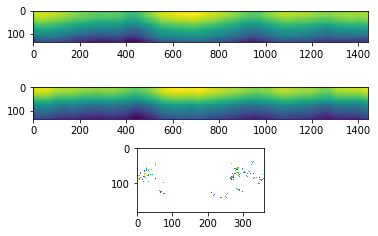

In [8]:
fig, ax = plt.subplots(3,1)
ax[0].imshow(np.log10(pwr_maps['day'].T))
ax[1].imshow(np.log10(pwr_maps['night'].T))
ax[2].imshow(np.log10(cur_map))

In [9]:
# Load 3hr averages for the flash map (magnetic coordinates, since they look ugly at the equator in CGM)
avg_path  = 'outputs/GLDstats_v11/MAG/year_avgs/'

mag_avgs = dict()

d = os.listdir(avg_path)
files = [x for x in d if x.endswith('.pklz')]
for fi in files:
    outfile = os.path.join(avg_path, fi)
    
    with gzip.open(outfile,'rb') as f:
        print(f'loading {outfile}')
        thingy = pickle.load(f)
        for el in ['pwr_map','flash_map','cur_map']:
            if el in mag_avgs:
                mag_avgs[el] += thingy[el]
            else:
                mag_avgs[el] = thingy[el]

                

loading outputs/GLDstats_v11/MAG/year_avgs/04_28_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_11_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_04_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_27_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_18_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_09_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_14_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_01_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_13_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_06_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_20_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_02_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_17_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_23_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_06_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/08_14_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_01_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_10_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_05_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_26_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_19_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_24_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_31_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_29_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_27_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_29_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_22_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_10_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_05_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_08_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/09_08_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_19_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_12_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_07_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_20_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_29_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_27_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_12_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_07_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_25_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_24_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_20_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_20_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_24_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_03_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/10_14_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_24_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_31_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_04_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_11_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_19_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_20_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_21_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_24_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_08_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_31_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_05_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_10_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_07_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_12_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/07_24_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_08_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_26_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_28_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_05_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_22_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_10_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_18_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_10_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_05_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_29_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_27_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_24_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_08_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_12_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/02_05_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_21_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_18_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_02_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_17_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_22_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_15_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_23_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_09_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_15_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_20_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_18_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_10_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_05_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_30_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/01_29_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_27_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_11_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_04_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_31_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_24_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_15_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_25_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_30_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_09_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_05_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_29_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_10_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_08_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_02_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/09_09_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_16_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_03_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_11_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_04_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_28_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_23_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_13_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_06_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_30_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_25_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_28_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_26_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_22_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_23_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/11_01_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_14_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_08_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_22_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_19_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_16_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_03_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_08_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_05_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_10_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_12_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_07_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_25_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_28_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_26_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/10_05_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_10_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_28_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_26_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_08_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_31_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_24_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_14_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_01_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_25_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_30_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_26_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_07_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_12_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_18_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/11_30_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_25_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_22_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_20_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_02_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_17_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_21_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_22_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_15_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_18_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_09_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_02_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_17_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_30_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_25_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/02_10_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_05_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_27_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_06_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_13_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_02_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_19_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_17_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_15_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_30_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_25_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_01_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_14_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_02_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_09_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/04_15_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_27_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_23_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_04_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_11_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_19_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_14_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_01_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_19_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_17_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_02_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_21_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_20_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_15_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_25_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/02_06_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_04_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_11_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_16_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_03_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_29_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_24_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_31_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_19_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_04_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_26_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_11_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_23_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_29_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_16_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/04_07_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_09_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_08_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_31_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_24_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_11_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_04_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_29_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_21_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_14_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_01_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_15_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_20_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_03_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_18_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/03_13_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_06_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_08_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_22_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_10_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_05_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_02_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_19_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_17_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_10_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_05_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_01_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_14_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_15_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_22_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/05_01_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_14_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_08_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_28_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_20_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_02_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_17_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_19_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_18_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_22_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_24_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_31_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_20_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_26_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_06_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/10_01_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_14_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_01_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_03_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_16_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_26_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_17_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_19_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_02_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_10_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_05_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_14_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_01_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_24_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_31_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/05_05_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_31_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_24_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_14_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_01_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_09_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_26_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_22_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_24_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_07_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_12_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_29_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_10_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_05_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_15_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/11_22_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_19_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_20_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_27_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/08_22_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_15_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_08_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_22_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_12_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_07_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_03_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_16_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/01_27_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_17_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_02_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/06_01_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_01_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_14_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_18_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_02_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_17_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/02_19_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/04_28_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_04_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_11_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_13_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_06_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_30_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_25_T12-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/11_28_T18-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

loading outputs/GLDstats_v11/MAG/year_avgs/01_25_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_10_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_05_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_06_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/06_13_T06-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/10_18_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_11_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/07_04_T15-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_28_T03-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_05_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/03_10_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/05_21_T21-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/12_25_T09-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_02_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_avgs/09_17_T00-00-00.pklz
loading outputs/GLDstats_v11/MAG/year_av

In [10]:
R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.
dlon = 1
dlat = 1
print(np.shape(gridlats))
print(np.shape(mag_avgs['cur_map']))

sec_in_year = 60*60*24*365.25
cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(gridlats) + dlat/2.0)*D2R))

cmt = mag_avgs['cur_map']/len(files)
cmt /= file_duration
# cmt *= sec_in_year
cmt /= (1000.*1000)
cmt /= cell_areas[:,np.newaxis]
cmt = np.log10(cmt)
cmt[np.isinf(cmt)] = -100

(181,)
(181, 360)


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


dict_keys(['day', 'night'])
-100.0 -2.524987898184579


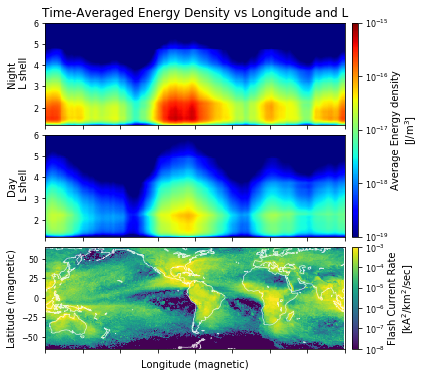

In [43]:
# Area of each cell, in km: 
# R_E = 6371. # Km
# R2D = 180./np.pi
# D2R = np.pi/180.
# dlon = 1
# dlat = 1
# sec_in_year = 60*60*24*365.25
# cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(gridlats) + dlat/2.0)*D2R))

# Load coastlines (for plotting)
with gzip.open('data/mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file, encoding='latin1' )

print(pwr_maps.keys())
%matplotlib inline


# --------------- Latex Plot Beautification --------------------------
fig_width = 5 
fig_height = 5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------
# fig, ax = plt.subplots(3,1)
clims = [-19, -15]

fig = plt.figure()
gs = gridspec.GridSpec(3,2, width_ratios=[1,0.02])
gs.update(wspace=0.05, hspace=0.1) # set the spacing between axes.
ax = []
ax.append(plt.subplot(gs[0,0]))
ax.append(plt.subplot(gs[1,0], sharex=ax[0]))
ax.append(plt.subplot(gs[2,0], sharex=ax[1]))
cax = plt.subplot(gs[0:2,1])
cax2= plt.subplot(gs[2,1])

# day_data = pwr_maps_thesis_method_normalized['day'].T
# night_data=pwr_maps_thesis_method_normalized['night'].T
day_data = pwr_maps_total['day'].T
night_data=pwr_maps_total['night'].T



p0 = ax[0].pcolormesh(gridlons_out, gridLs, night_data,  cmap = plt.get_cmap('jet'),
                      vmin=clims[0], vmax=clims[1])#, shading='gouraud')
p1 = ax[1].pcolormesh(gridlons_out, gridLs, day_data, cmap = plt.get_cmap('jet'),
                      vmin=clims[0], vmax=clims[1])#, shading='gouraud')
ax[0].set_ylim([1.2, 6])
ax[1].set_ylim([1.2, 6])

# Colorbar
cb = plt.colorbar(p0, cax=cax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Average Energy density\n[J/m$^3$]') 

clims2 = [-8, -3]
print(np.min(cmt), np.max(cmt))
p3 = ax[2].pcolormesh(np.arange(-180,180), np.arange(-90, 91), cmt, vmin=clims2[0], vmax=clims2[1],
                      cmap = plt.get_cmap('viridis'))#, shading='gouraud')
ax[2].plot(coast['lon'], coast['lat'], color='w', alpha=0.8, linewidth=0.7)
ax[2].set_xlim([-180, 179])
ax[2].set_ylim([-65, 65])
# ax[2].set_aspect('equal')

# Colorbar
cb2 = plt.colorbar(p3, cax=cax2)
cticks = np.arange(clims2[0],clims2[1] + 1)
cb2.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb2.set_ticklabels(cticklabels)
cb2.set_label('Flash Current Rate\n[kA$^2$/km$^2$/sec]') 

xtix = np.arange(-180, 181, 45) 

# [a.set_xlim([-180,0]) for a in ax]
ax[0].set_xticks(xtix)
ax[1].set_xticks(xtix)
ax[2].set_xticks(xtix)
ax[0].set_xticklabels([])
ax[0].set_ylabel('Night\n L shell')
ax[1].set_ylabel('Day\n L shell')
ax[1].set_xticklabels([])
ax[2].set_xlabel('Longitude (magnetic)')
ax[2].set_ylabel('Latitude (magnetic)')
# ax[2].set_aspect('equal')
ax[0].set_title('Time-Averaged Energy Density vs Longitude and L')
# gs.tight_layout(fig)

fig.subplots_adjust(right=0.85)

fig.savefig('Energy_density_daynite_2_2020_CGM.png',dpi=300, transparent = True)

In [57]:
print(np.max(pwr_maps_thesis_method_normalized['day']))
print(np.max(pwr_maps_thesis_method_normalized['night']))
print(np.max(pwr_maps_total['day']))
print(np.max(pwr_maps_total['night']))








-16.286176236040887
-15.356239755636466
-16.124753246507932
-15.237005355961076
1.1831052043111322e-10
9.136319010397243e-10


0 1440
[-14.68386844  -0.88276925]


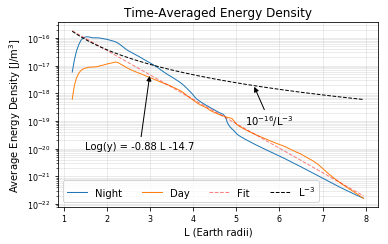

In [102]:
import scipy.optimize

# Line plot of day + night trends over the US:
# --------------- Latex Plot Beautification --------------------------
fig_width = 4.5 
fig_height = 2.5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


dens_vs_L = dict()

# lonlims = [-50, 10]  # ~ approximately over the US
lonlims = [-180, 180]  # ~ approximately over the US

left_ind  = bisect.bisect_left(gridlons, lonlims[0])
right_ind = bisect.bisect_left(gridlons, lonlims[1])

print(left_ind, right_ind)

for k in pwr_maps.keys():
    dens_vs_L[k] = (period_factor/n_averaged)*np.sum(pwr_maps_linear[k][left_ind:right_ind, :], axis=0)/(right_ind - left_ind)
    


def func(x, a, b):
    return a + b*x
popt, pcov = scipy.optimize.curve_fit(func, gridLs, np.log10((dens_vs_L['day'] + dens_vs_L['night'])/2.))

print(popt)




fit = func(gridLs, popt[0], popt[1])
fig, ax = plt.subplots(1,1)
ax.semilogy(gridLs, dens_vs_L['night'], linewidth=1, label='Night')
ax.semilogy(gridLs, dens_vs_L['day'], linewidth=1, label='Day')
ax.semilogy(gridLs, pow(10,fit), '--',linewidth=1, label='Fit', alpha=0.5, color='r')


Lcube_trend = (3e-16)*pow(gridLs, -3)
ax.plot(gridLs, Lcube_trend, 'k--', linewidth=1, label='L$^{-3}$')

ax.annotate(xy=(5.4, 2e-18),xytext=(5.2,7e-20),s="10$^{-16}$/L$^{-3}$",arrowprops={'arrowstyle':'-|>','facecolor':'k'})
ax.annotate(xy=(3, 5e-18), xytext=(1.5, 1e-20), s="Log(y) = %2.2f L %2.1f"%(popt[1], popt[0]), arrowprops={'arrowstyle':'-|>','facecolor':'k'})

# ax.legend(loc='upper right')





# ax.set_ylim([-18, -14])
ax.grid('on', which='both', linestyle='-', alpha=0.3)
ax.legend(ncol=4)

# ax.text(2, 1e-20, "Log(y) = %2.2f L %2.1f"%(popt[1], popt[0]))
ax.set_xlabel('L (Earth radii)')
ax.set_ylabel('Average Energy Density [J/m$^3$]')
ax.set_title('Time-Averaged Energy Density')#\n between %d$^o$ and %d$^o$ longitude'%(lonlims[0], lonlims[1]))
fig.tight_layout()
fig.savefig('density_vs_L_2_2020.pdf',dpi=300)

In [62]:
# Load and look at the data from my thesis:

with gzip.open('data/energy_density_daynite.gzip','rb') as file:
    d = pickle.load(file, encoding ='latin1')
    
t_gridlats = d['gridlats']
t_gridlons = d['gridlons']
t_gridLs = d['gridLs']
t_pwr_maps_total = d['pwr_map_total']
t_pwr_maps_linear = d['pwr_map_linear']
t_cmt = d['cur_map']

In [63]:
print(t_gridlats)

[-90 -89 -88 -87 -86 -85 -84 -83 -82 -81 -80 -79 -78 -77 -76 -75 -74 -73
 -72 -71 -70 -69 -68 -67 -66 -65 -64 -63 -62 -61 -60 -59 -58 -57 -56 -55
 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37
 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19
 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1
   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89]


-0.6658629840772576
-0.43849791743453304
0.3806149048759733
dict_keys(['day', 'night'])
-100.0 -2.524987898184579


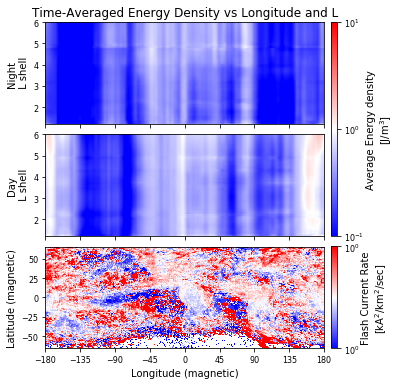

In [80]:
nite_diff = night_data - t_pwr_maps_total[0].T
day_diff  = day_data - t_pwr_maps_total[12].T
cmt_diff = cmt[:-1,:] - t_cmt

print(np.mean(nite_diff))
print(np.mean(day_diff))
print(np.mean(cmt_diff))
# Area of each cell, in km: 
# R_E = 6371. # Km
# R2D = 180./np.pi
# D2R = np.pi/180.
# dlon = 1
# dlat = 1
# sec_in_year = 60*60*24*365.25
# cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(gridlats) + dlat/2.0)*D2R))

# Load coastlines (for plotting)
with gzip.open('data/mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file, encoding='latin1' )

print(pwr_maps.keys())

# --------------- Latex Plot Beautification --------------------------
fig_width = 5 
fig_height = 5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

# fig, ax = plt.subplots(3,1)
clims = [-1, 1]

fig = plt.figure()
gs = gridspec.GridSpec(3,2, width_ratios=[1,0.02])
gs.update(wspace=0.05, hspace=0.1) # set the spacing between axes.
ax = []
ax.append(plt.subplot(gs[0,0]))
ax.append(plt.subplot(gs[1,0]))
ax.append(plt.subplot(gs[2,0]))
cax = plt.subplot(gs[0:2,1])
cax2= plt.subplot(gs[2,1])

# day_data = pwr_maps_thesis_method_normalized['day'].T
# night_data=pwr_maps_thesis_method_normalized['night'].T
day_data = pwr_maps_total['day'].T
night_data=pwr_maps_total['night'].T



p0 = ax[0].pcolormesh(gridlons_out, gridLs, nite_diff,  cmap = plt.get_cmap('bwr'),
                      vmin=clims[0], vmax=clims[1])#, shading='gouraud')
p1 = ax[1].pcolormesh(gridlons_out, gridLs, day_diff, cmap = plt.get_cmap('bwr'),
                      vmin=clims[0], vmax=clims[1])#, shading='gouraud')
ax[0].set_ylim([1.2, 6])
ax[1].set_ylim([1.2, 6])

# Colorbar
cb = plt.colorbar(p0, cax=cax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Average Energy density\n[J/m$^3$]') 

clims2 = [-0.5, 0.5]
print(np.min(cmt), np.max(cmt))
p3 = ax[2].pcolormesh(np.arange(-180,180), np.arange(-90, 91), cmt_diff, vmin=clims2[0], vmax=clims2[1],
                      cmap = plt.get_cmap('bwr'))#, shading='gouraud')
ax[2].plot(coast['lon'], coast['lat'], color='w', alpha=0.8, linewidth=0.7)
ax[2].set_xlim([-180, 179])
ax[2].set_ylim([-65, 65])
# ax[2].set_aspect('equal')

# Colorbar
cb2 = plt.colorbar(p3, cax=cax2)
cticks = np.arange(clims2[0],clims2[1] + 1)
cb2.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb2.set_ticklabels(cticklabels)
cb2.set_label('Flash Current Rate\n[kA$^2$/km$^2$/sec]') 

xtix = np.arange(-180, 181, 45) 
ax[0].set_xticks(xtix)
ax[1].set_xticks(xtix)
ax[2].set_xticks(xtix)
ax[0].set_xticklabels([])
ax[0].set_ylabel('Night\n L shell')
ax[1].set_ylabel('Day\n L shell')
ax[1].set_xticklabels([])
ax[2].set_xlabel('Longitude (magnetic)')
ax[2].set_ylabel('Latitude (magnetic)')
ax[2].set_aspect('equal')
ax[0].set_title('Time-Averaged Energy Density vs Longitude and L')
# gs.tight_layout(fig)

fig.subplots_adjust(right=0.8)

# fig.savefig('Energy_density_daynite_1_2020_CGM.png',dpi=300)


(array([2.000e+00, 4.000e+00, 3.000e+00, 1.000e+01, 1.500e+01, 8.000e+00,
        2.100e+01, 1.600e+01, 3.100e+01, 2.400e+01, 2.300e+01, 4.800e+01,
        4.900e+01, 5.600e+01, 7.000e+01, 6.100e+01, 9.000e+01, 9.000e+01,
        1.070e+02, 9.800e+01, 1.190e+02, 1.100e+02, 1.190e+02, 1.280e+02,
        1.330e+02, 1.100e+02, 1.270e+02, 1.290e+02, 1.160e+02, 1.310e+02,
        1.520e+02, 1.330e+02, 1.170e+02, 1.220e+02, 1.130e+02, 1.370e+02,
        1.220e+02, 1.400e+02, 1.420e+02, 1.540e+02, 1.690e+02, 1.560e+02,
        2.000e+02, 1.740e+02, 1.900e+02, 2.160e+02, 2.170e+02, 2.680e+02,
        2.830e+02, 2.960e+02, 3.440e+02, 3.630e+02, 4.200e+02, 4.780e+02,
        4.500e+02, 5.220e+02, 5.750e+02, 6.130e+02, 6.820e+02, 7.580e+02,
        8.570e+02, 9.090e+02, 9.900e+02, 1.070e+03, 1.222e+03, 1.225e+03,
        1.292e+03, 1.369e+03, 1.370e+03, 1.434e+03, 1.528e+03, 1.534e+03,
        1.728e+03, 1.736e+03, 1.759e+03, 1.652e+03, 1.592e+03, 1.465e+03,
        1.265e+03, 1.157e+03, 1.116e+0

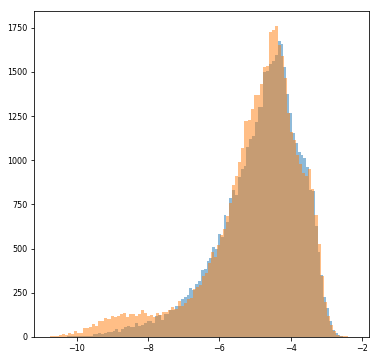

In [92]:
fig, ax = plt.subplots(1,1)
ax.hist(cmt[cmt!=-100].ravel(),bins=100, alpha=0.5)
ax.hist(t_cmt[t_cmt!=-100].ravel(),bins=100, alpha=0.5)

0.9030899869919435


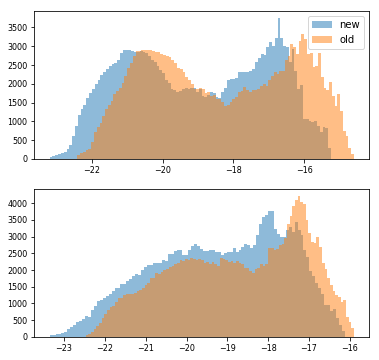

In [102]:
# Histograms of the output energies, comparing with thesis work.
print(np.log10(8))
fig, ax = plt.subplots(2,1)
ax[0].hist(night_data.ravel(),bins=100, alpha=0.5, label='new');
ax[0].hist(t_pwr_maps_total[0].T.ravel(),bins=100, alpha=0.5, label='old');
ax[1].hist(day_data.ravel(),bins=100, alpha=0.5);
ax[1].hist(t_pwr_maps_total[12].T.ravel(),bins=100, alpha=0.5);
ax[0].legend()

## Line plot, energy density vs L

In [49]:
dens_vs_L

{'day': array([3.63413890e-13, 9.58760566e-13, 2.04507212e-12, 3.45527730e-12,
        4.59208663e-12, 5.32412536e-12, 5.95303107e-12, 6.51575260e-12,
        6.94053444e-12, 7.12082965e-12, 7.29408059e-12, 7.37799645e-12,
        7.49889987e-12, 7.68783437e-12, 7.90922207e-12, 8.18037455e-12,
        8.40687394e-12, 8.46010291e-12, 8.38253109e-12, 8.50216229e-12,
        9.36424726e-12, 1.02527347e-11, 9.80451667e-12, 8.98961373e-12,
        8.28405305e-12, 7.58678275e-12, 6.91448384e-12, 6.36285471e-12,
        5.88999782e-12, 5.52590980e-12, 5.21473814e-12, 4.91188766e-12,
        4.59950169e-12, 4.29397125e-12, 3.99633684e-12, 3.72307187e-12,
        3.46569781e-12, 3.19653349e-12, 2.94608900e-12, 2.74119147e-12,
        2.54041862e-12, 2.34730659e-12, 2.17275732e-12, 2.02843193e-12,
        1.89885218e-12, 1.76677953e-12, 1.61981293e-12, 1.49961828e-12,
        1.40584510e-12, 1.32586023e-12, 1.27196351e-12, 1.16717333e-12,
        9.89396649e-13, 8.41496710e-13, 7.31801084e-13, 6